<a href="https://colab.research.google.com/github/DenisPushkin/WGANGP/blob/master/WGANGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wasserstein GAN with gradient penalty (WGANGP)

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import skimage.transform
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import ast
print(tf.__version__)

2.2.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
InceptionV3_model = tf.keras.applications.InceptionV3()

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = skimage.transform.resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)
 
# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=1, eps=1E-16):
	# enumerate splits of images/predictions
	scores = list()
	n_part = np.int(np.floor(images.shape[0] / n_split))
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		subset = subset / 1.0
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))
		# pre-process images, scale to [-1,1]
    #subset = tf.keras.applications.inception_v3.preprocess_input(subset)
		# predict p(y|x)
		p_yx = InceptionV3_model.predict(subset)
		# calculate p(y)
		p_y = np.expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = np.mean(sum_kl_d)
		# undo the log
		is_score = np.exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg = np.mean(scores)
	return is_avg

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
"""
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train[:,:,:,np.newaxis]
x_train = x_train/255.
"""
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[:,:,:,np.newaxis]
x_train = x_train/127.5 - 1 #to [-1, 1] range

print(x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


In [ ]:
class OptimisticAdam:

    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='optimistic_adam'):

        self.learning_rate = tf.constant(learning_rate, dtype=tf.float32)
        self.beta_1 = tf.constant(beta_1, dtype=tf.float32)
        self.beta_2 = tf.constant(beta_2, dtype=tf.float32)
        self.epsilon = tf.constant(epsilon, dtype=tf.float32)
        self.m = {}
        self.v = {}
        self.lr_prev = {}
        self.t = {}
    
    def apply_gradients(self, grads_and_vars):
        for grad, var in grads_and_vars:
            if var.name not in self.t.keys():
                self.t[var.name] = 1
            else:
                self.t[var.name] += 1
            if var.name not in self.m.keys():
                self.m[var.name] = tf.zeros(shape=var.shape, dtype=tf.float32)
            self.m[var.name] = self.beta_1*self.m[var.name] + (1-self.beta_1)*grad
            if var.name not in self.v.keys():
                self.v[var.name] = tf.zeros(shape=var.shape, dtype=tf.float32)
            self.v[var.name] = self.beta_2*self.v[var.name] + (1-self.beta_2)*tf.math.multiply(grad,grad)
            m_head = self.m[var.name] / (1 - math.pow(self.beta_1, self.t[var.name]))
            v_head = self.v[var.name] / (1 - math.pow(self.beta_2, self.t[var.name]))
            lr_t = m_head / tf.sqrt(v_head + self.epsilon)
            if var.name not in self.lr_prev.keys():
                self.lr_prev[var.name] = lr_t

            var.assign_sub(2*self.learning_rate*lr_t)
            var.assign_add(self.learning_rate*self.lr_prev[var.name])

            self.lr_prev[var.name] = lr_t

class ExtraAdam(tf.keras.optimizers.Adam):
    """
    ExtraAdam optimizer is actually Adam optimizer, but depending of optimizer's type
    disc_backpropagation and gen_backpropagation functions of the model behave differently.
    They contain the following if-claus:
    
    if type(optimizer) == ExtraAdam:
        ...

    """
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='extra_adam'):
        super(ExtraAdam, self).__init__(learning_rate, beta_1, beta_2, epsilon)


In [ ]:
def get_generator():
    #init = tf.keras.initializers.RandomNormal(stddev=0.02)
    inputs = Input(shape = 128)
    h = Dense(units = 4*4*256, activation = 'relu')(inputs)
    h = Reshape(target_shape=[4,4,256])(h)
    h = Conv2DTranspose(filters = 128, kernel_size = (5,5), strides = (2,2), padding='same', activation = 'relu')(h)
    h = Conv2DTranspose(filters = 64, kernel_size = (5,5), strides = (2,2), padding='same', activation = 'relu')(h)
    h = Conv2DTranspose(filters = 1, kernel_size = (5,5), strides = (2,2), padding='same', activation='tanh')(h)
    outputs = h[:,2:-2,2:-2,:]
    generator = Model(inputs=inputs, outputs=outputs)
    return generator

def get_discriminator():
    discriminator = Sequential([
                                Input(shape=(28,28,1)),
                                Conv2D(64, (5,5), strides=(2,2), padding='same'),
                                LeakyReLU(0.2),
                                Conv2D(128, (5,5), strides=(2,2), padding='same'),
                                LeakyReLU(0.2),
                                Conv2D(256, (5,5), strides=(2,2), padding='same'),
                                LeakyReLU(0.2),
                                Flatten(),
                                Dense(1, activation='linear', use_bias=False) #bias does not have any effect on EM-distance
    ])
    return discriminator

In [ ]:
generator = get_generator()
generator.summary()
discriminator = get_discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              528384    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819328    
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 64)        204864    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 1)         1601      
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 28, 28, 1)]       0   

In [ ]:
#future version: add extra Adam
class WGANGP(Model):
    
    def __init__(self, optimizer, x_train, batch_size=64, use_averaging=False,
                 path='/content/drive/My Drive/Univ/Final models/Saved models/WGANGP Adam/'):
        super(WGANGP, self).__init__()
        self.discriminator = self.get_discriminator()
        self.generator = self.get_generator()
        self.latent_dimension = self.generator.get_layer('input_latent').input.shape[1]
        self.use_averaging = use_averaging
        self.generator_avr = self.get_generator() #saves average of variables
        self.batch_size = batch_size
        self.n_critic = 5
        self.lambd = 10. #gradient penalty parameter
        self.dataset_generator = self.get_train_dataset(x_train)
        #self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
        self.optimizer = optimizer
        self.losses_per_epoch = {'generator': [], 'discriminator': []}
        self.first_grads_mean_per_epoch = {'generator': [], 'discriminator': []}
        self.last_grads_mean_per_epoch = {'generator': [], 'discriminator': []}
        self.IS_per_epoch = [] #inception scores
        self.epoch = 0
        self.path = path
        self.train_steps_for_average = 0
        self.IS_for_avr_per_epoch = []

    def get_generator(self, latent_dim=128):
        inputs = Input(shape = (latent_dim,), name='input_latent')
        h = Dense(units = 4*4*256, activation = 'relu')(inputs)
        h = Reshape(target_shape=[4,4,256])(h)
        h = Conv2DTranspose(filters = 128, kernel_size = (5,5), strides = (2,2), padding='same', activation = 'relu')(h)
        h = Conv2DTranspose(filters = 64, kernel_size = (5,5), strides = (2,2), padding='same', activation = 'relu')(h)
        h = Conv2DTranspose(filters = 1, kernel_size = (5,5), strides = (2,2), padding='same', activation='tanh')(h)
        outputs = h[:,2:-2,2:-2,:]
        generator = Model(inputs=inputs, outputs=outputs)
        return generator
    
    def get_discriminator(self):
        discriminator = Sequential([
                                    Input(shape=(28,28,1)),
                                    Conv2D(64, (5,5), strides=(2,2), padding='same'),
                                    LeakyReLU(0.2),
                                    Conv2D(128, (5,5), strides=(2,2), padding='same'),
                                    LeakyReLU(0.2),
                                    Conv2D(256, (5,5), strides=(2,2), padding='same'),
                                    LeakyReLU(0.2),
                                    Flatten(),
                                    Dense(1, activation='linear', use_bias=False) #bias does not have any effect on EM-distance
        ])
        return discriminator

    def get_train_dataset(self, x_train):
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train,))
        train_dataset = train_dataset.batch(self.batch_size, drop_remainder=True)
        return train_dataset

    def sample_noise(self, batch_size = None):
        if batch_size == None:
            batch_size = self.batch_size
        return np.random.normal(size = (batch_size, self.latent_dimension))

    def gradient_penalty(self, real_data, generated_data):
        batch_size = real_data.shape[0]
        alpha = tf.random.uniform([batch_size,1,1,1], minval=0., maxval=1.)
        diff = generated_data - real_data
        medium_data = real_data + alpha*diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(medium_data)
            pred = self.discriminator(medium_data, training=True)
        grads = gp_tape.gradient(pred, [medium_data])
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3]))
        gp = tf.reduce_mean((norm-1.)**2)
        return gp

    @tf.function
    def disc_backpropagation(self, real_data, generated_data):
        if type(self.optimizer) == ExtraAdam:
            (disc_loss, disc_grads) = self.disc_backpropagation_for_extraadam(real_data, generated_data)
        else:
            with tf.GradientTape() as tape:
                preds_on_real = self.discriminator(real_data)
                preds_on_generated = self.discriminator(generated_data)
                d_cost = preds_on_generated - preds_on_real
                gp = self.gradient_penalty(real_data, generated_data)
                disc_loss = d_cost + self.lambd*gp
            disc_grads = tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))
        return (disc_loss, disc_grads)

    def disc_backpropagation_for_extraadam(self, real_data, generated_data):
        indexes = np.arange(self.batch_size)
        np.random.shuffle(indexes)
        real_data_2 = tf.gather(real_data, indexes[self.batch_size//2:])
        generated_data_2 = tf.gather(generated_data, indexes[self.batch_size//2:])
        real_data = tf.gather(real_data, indexes[:self.batch_size//2])
        generated_data = tf.gather(generated_data, indexes[:self.batch_size//2])

        with tf.GradientTape() as tape:
            preds_on_real = self.discriminator(real_data)
            preds_on_generated = self.discriminator(generated_data)
            d_cost = preds_on_generated - preds_on_real
            gp = self.gradient_penalty(real_data, generated_data)
            disc_loss = d_cost + self.lambd*gp
        disc_grads = tape.gradient(disc_loss, self.discriminator.trainable_variables)
        prev_trainable_variables = self.discriminator.trainable_variables
        self.optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        with tf.GradientTape() as tape:
            preds_on_real_2 = self.discriminator(real_data_2)
            preds_on_generated_2 = self.discriminator(generated_data_2)
            d_cost_2 = preds_on_generated_2 - preds_on_real_2
            gp_2 = self.gradient_penalty(real_data_2, generated_data_2)
            disc_loss_2 = d_cost_2 + self.lambd*gp_2
        disc_grads_2 = tape.gradient(disc_loss_2, self.discriminator.trainable_variables)
        for (v,x) in zip(self.discriminator.trainable_variables, prev_trainable_variables):
            v.assign(x)
        self.optimizer.apply_gradients(zip(disc_grads_2, self.discriminator.trainable_variables))
        return (disc_loss_2, disc_grads_2)

    @tf.function
    def generator_backpropagation(self, noise):
        if type(self.optimizer) == ExtraAdam:
            (gen_loss, gen_grads) = self.generator_backpropagation_for_extraadam(noise)      
        else:
            with tf.GradientTape() as tape:
                generated_data = self.generator(noise)
                preds_on_generated = self.discriminator(generated_data)
                gen_loss = (-1) * tf.reduce_mean(preds_on_generated)
            gen_grads = tape.gradient(gen_loss, self.generator.trainable_variables)
            self.optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        return (gen_loss, gen_grads)

    def generator_backpropagation_for_extraadam(self, noise):
        indexes = np.arange(self.batch_size)
        noise_2 = tf.gather(noise, indexes[self.batch_size//2:])
        noise = tf.gather(noise, indexes[:self.batch_size//2])

        with tf.GradientTape() as tape:
            generated_data = self.generator(noise)
            preds_on_generated = self.discriminator(generated_data)
            gen_loss = (-1) * tf.reduce_mean(preds_on_generated)
        gen_grads = tape.gradient(gen_loss, self.generator.trainable_variables)
        prev_trainable_variables = self.generator.trainable_variables
        self.optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))

        with tf.GradientTape() as tape:
            generated_data_2 = self.generator(noise_2)
            preds_on_generated_2 = self.discriminator(generated_data_2)
            gen_loss_2 = (-1) * tf.reduce_mean(preds_on_generated_2)
        gen_grads_2 = tape.gradient(gen_loss_2, self.generator.trainable_variables)
        for (v,x) in zip(self.generator.trainable_variables, prev_trainable_variables):
            v.assign(x)
        self.optimizer.apply_gradients(zip(gen_grads_2, self.generator.trainable_variables))
        return (gen_loss_2, gen_grads_2)
    
    def train(self, epochs):

        for epoch in range(epochs):
            
            batch_num = 0
            losses_per_batch = {'generator': tf.keras.metrics.Mean(), 'discriminator': tf.keras.metrics.Mean()}
            first_grads_mean_per_batch = {'generator': tf.keras.metrics.Mean(), 'discriminator': tf.keras.metrics.Mean()}
            last_grads_mean_per_batch = {'generator': tf.keras.metrics.Mean(), 'discriminator': tf.keras.metrics.Mean()}
            for real_data in self.dataset_generator:
                batch_num += 1
                real_data = tf.cast(real_data[0], dtype=tf.float32)
                if batch_num % self.n_critic == 0:
                    noise = self.sample_noise()
                    generated_data = self.generator(noise)
                    (disc_loss, disc_grads) = self.disc_backpropagation(real_data, generated_data)
                    noise = self.sample_noise()
                    (gen_loss, gen_grads) = self.generator_backpropagation(noise)

                    losses_per_batch['discriminator'](disc_loss)
                    losses_per_batch['generator'](gen_loss)
                    first_grads_mean_per_batch['generator'](tf.math.reduce_mean(tf.abs(gen_grads[0])))
                    last_grads_mean_per_batch['generator'](tf.math.reduce_mean(tf.abs(gen_grads[-2])))
                    first_grads_mean_per_batch['discriminator'](tf.math.reduce_mean(tf.abs(disc_grads[0])))
                    #last layer of discriminator does not contain bias variable
                    last_grads_mean_per_batch['discriminator'](tf.math.reduce_mean(tf.abs(disc_grads[-1])))
                else:
                    noise = self.sample_noise()
                    generated_data = self.generator(noise)
                    (disc_loss, disc_grads) = self.disc_backpropagation(real_data, generated_data)
                if self.use_averaging:
                    self.update_avr_variables()
                    
            self.losses_per_epoch['generator'].append(losses_per_batch['generator'].result().numpy())
            self.losses_per_epoch['discriminator'].append(losses_per_batch['discriminator'].result().numpy())
            self.first_grads_mean_per_epoch['generator'].append(first_grads_mean_per_batch['generator'].result().numpy())
            self.last_grads_mean_per_epoch['generator'].append(last_grads_mean_per_batch['generator'].result().numpy())
            self.first_grads_mean_per_epoch['discriminator'].append(first_grads_mean_per_batch['discriminator'].result().numpy())
            self.last_grads_mean_per_epoch['discriminator'].append(last_grads_mean_per_batch['discriminator'].result().numpy())
            
            self.epoch += 1
            self.update_IS()
            self.print_state()
            if self.epoch % 1 == 0:
                print('examples of generated images after', self.epoch, 'epochs')
                self.draw_generated_images(rows=4, cols=6)
                if self.use_averaging:
                    print('examples of generated images using average variables after', self.epoch, 'epochs')
                    self.draw_generated_images(rows=4, cols=6, is_from_gen_avr=True)
            if self.epoch % 5 == 0:
                self.save_state_to_file()

    def update_avr_variables(self):
        self.train_steps_for_average += 1
        for (v,x) in zip(self.generator_avr.trainable_variables, self.generator.trainable_variables):
            v.assign((1.0/self.train_steps_for_average) * x + (1 - 1.0/self.train_steps_for_average) * v)

    def update_IS(self):
        self.IS_per_epoch.append(calculate_inception_score(self.generate(1000)))
        if self.use_averaging:
            self.IS_for_avr_per_epoch.append(calculate_inception_score(self.generate(1000, is_from_gen_avr=True)))

    def generate(self, num=1, is_from_gen_avr=False):
        
        noise = self.sample_noise(batch_size = num)
        if is_from_gen_avr:
            generated_data = self.generator_avr(noise)
        else:
            generated_data = self.generator(noise)
        return generated_data
    
    def draw_generated_images(self, rows, cols, is_from_gen_avr=False):
        images = self.generate(rows*cols, is_from_gen_avr)
        plt.figure(figsize = (3*cols, 3*rows))
        for i in range(rows*cols):
            plt.subplot(rows, cols, i+1)
            plt.imshow(images[i,:,:,0], cmap='gray')
        plt.show()

    def save_state_to_file(self):
        gen_path = self.path + 'gen_{:03d}_epochs/gen_{:03d}_epochs'.format(self.epoch,self.epoch)                 
        self.generator.save_weights(gen_path)
        disc_path = self.path + 'disc_{:03d}_epochs/disc_{:03d}_epochs'.format(self.epoch,self.epoch)
        self.discriminator.save_weights(disc_path)
        if self.use_averaging:
            gen_avr_path = self.path + 'gen_avr_{:03d}_epochs/gen_avr_{:03d}_epochs'.format(self.epoch,self.epoch)
            self.generator_avr.save_weights(gen_avr_path)
        train_info_path = self.path + 'train_info_{:03d}.txt'.format(self.epoch)
        f=open(train_info_path,'w')
        f.write(str(self.losses_per_epoch['generator']) + '\n')
        f.write(str(self.losses_per_epoch['discriminator']) + '\n')
        f.write(str(self.first_grads_mean_per_epoch['generator']) + '\n')
        f.write(str(self.first_grads_mean_per_epoch['discriminator']) + '\n')
        f.write(str(self.last_grads_mean_per_epoch['generator']) + '\n')
        f.write(str(self.last_grads_mean_per_epoch['discriminator']) + '\n')
        f.write(str(self.IS_per_epoch) + '\n')
        f.write(str(self.IS_for_avr_per_epoch) + '\n')
        f.close()
    
    def print_state(self):
        if self.use_averaging:
            print("Epoch: {:03d}: Gen Loss: {:.3f}, Disc Loss:{:.3f}, IS: {:.3f}, IS_avr: {:.3f}".format(self.epoch,
                                                                self.losses_per_epoch['generator'][-1],
                                                                self.losses_per_epoch['discriminator'][-1],
                                                                self.IS_per_epoch[-1],
                                                                self.IS_for_avr_per_epoch[-1]))
        else:
            print("Epoch: {:03d}: Gen Loss: {:.3f}, Disc Loss:{:.3f}, IS: {:.3f}".format(self.epoch,
                                                                self.losses_per_epoch['generator'][-1],
                                                                self.losses_per_epoch['discriminator'][-1],
                                                                self.IS_per_epoch[-1]))
    
    def draw_IS_per_epoch_graphic(self, is_from_gen_avr=False):
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(6, 5))  
        axes.set_xlabel("Epochs", fontsize=14)
        axes.set_ylabel("IS", fontsize=14)
        if is_from_gen_avr:
            axes.set_title('IS gen_avr vs epochs')
        else:
            axes.set_title('IS vs epochs')
        if is_from_gen_avr:
            axes.plot(self.IS_for_avr_per_epoch)
        else:
            axes.plot(self.IS_per_epoch)
        plt.show()
    
    def draw_losses_per_epoch_graphic(self):
        fig, axes = plt.subplots(1, 3, sharex=True, figsize=(18, 5))

        axes[0].set_xlabel("Epochs", fontsize=14)
        axes[0].set_ylabel("Loss", fontsize=14)
        axes[0].set_title('Generator Loss vs epochs')
        axes[0].plot(self.losses_per_epoch['generator'])

        axes[1].set_title('Discriminator Loss vs Epochs')
        axes[1].set_ylabel("Loss", fontsize=14)
        axes[1].set_xlabel("Epochs", fontsize=14)
        axes[1].plot(self.losses_per_epoch['discriminator'])

        axes[2].set_title('Distributions EM-distanse')
        axes[2].set_ylabel("EM-distanse", fontsize=14)
        axes[2].set_xlabel("Epochs", fontsize=14)
        axes[2].plot([-1*loss for loss in self.losses_per_epoch['discriminator']])
        plt.show()
    
    def draw_grads_per_epoch_graphic(self):
        fig, axes = plt.subplots(2, 2, sharex=True, figsize=(12, 12))

        axes[0,0].set_xlabel("Epochs", fontsize=14)
        axes[0,0].set_ylabel("Grads", fontsize=14)
        axes[0,0].set_title('Generator first grads mean vs epochs')
        axes[0,0].plot(self.first_grads_mean_per_epoch['generator'])

        axes[0,1].set_xlabel("Epochs", fontsize=14)
        axes[0,1].set_ylabel("Grads", fontsize=14)
        axes[0,1].set_title('Generator last grads mean vs epochs')
        axes[0,1].plot(self.last_grads_mean_per_epoch['generator'])

        axes[1,0].set_xlabel("Epochs", fontsize=14)
        axes[1,0].set_ylabel("Grads", fontsize=14)
        axes[1,0].set_title('Discriminator first grads mean vs epochs')
        axes[1,0].plot(self.first_grads_mean_per_epoch['discriminator'])

        axes[1,1].set_xlabel("Epochs", fontsize=14)
        axes[1,1].set_ylabel("Grads", fontsize=14)
        axes[1,1].set_title('Discriminator last grads mean vs epochs')
        axes[1,1].plot(self.last_grads_mean_per_epoch['discriminator'])

        plt.show()
    
    def upload_from_file(self, epoch=1):
        path = self.path
        self.epoch = epoch
        gen_path = path + 'gen_{:03d}_epochs/gen_{:03d}_epochs'.format(epoch,epoch)
        self.generator.load_weights(gen_path)
        disc_path = path + 'disc_{:03d}_epochs/disc_{:03d}_epochs'.format(epoch,epoch)
        self.discriminator.load_weights(disc_path)
        if self.use_averaging:
            gen_avr_path = path + 'gen_avr_{:03d}_epochs/gen_avr_{:03d}_epochs'.format(epoch,epoch)
            self.generator_avr.load_weights(gen_avr_path)
        path = path + 'train_info_{:03d}.txt'.format(epoch)
        f = open(path,'r')
        train_info = f.read()
        train_info = train_info.split(sep='\n')
        train_info = [elem[12:-1] for elem in train_info]
        self.losses_per_epoch['generator'] = ast.literal_eval(train_info[0])
        self.losses_per_epoch['discriminator'] = ast.literal_eval(train_info[1])
        self.first_grads_mean_per_epoch['generator'] = ast.literal_eval(train_info[2])
        self.first_grads_mean_per_epoch['discriminator'] = ast.literal_eval(train_info[3])
        self.last_grads_mean_per_epoch['generator'] = ast.literal_eval(train_info[4])
        self.last_grads_mean_per_epoch['discriminator'] = ast.literal_eval(train_info[5])
        self.IS_per_epoch = ast.literal_eval(train_info[6])
        self.IS_for_avr_per_epoch = ast.literal_eval(train_info[7])

**Adam**

Epoch: 001: Gen Loss: -0.445, Disc Loss:-1.320, IS: 2.368
examples of generated images after 1 epochs


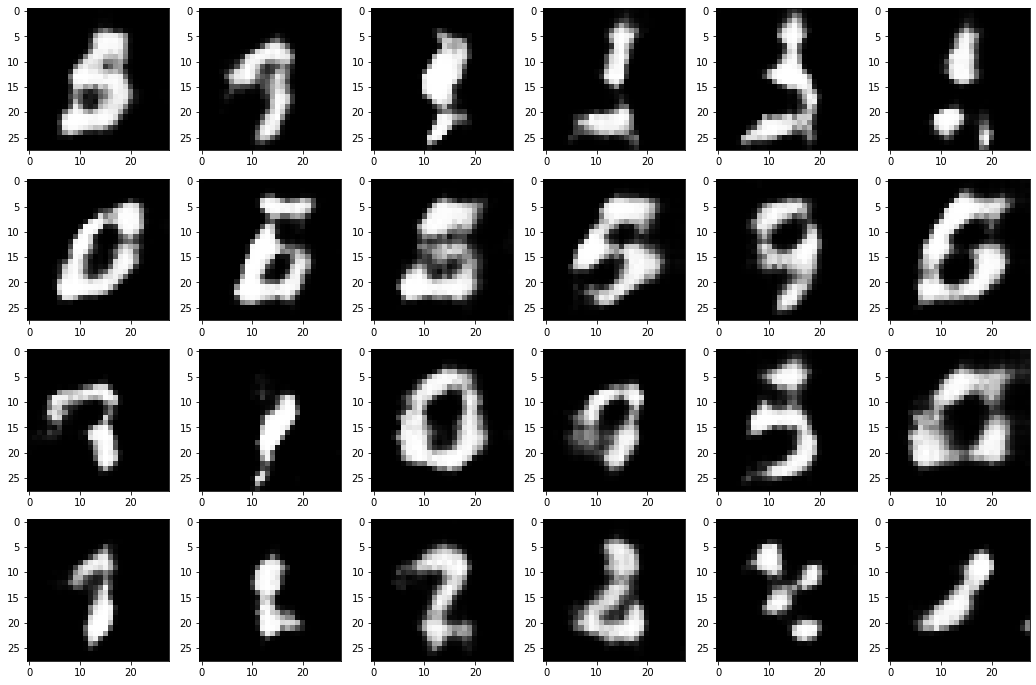

Epoch: 002: Gen Loss: -0.640, Disc Loss:-0.653, IS: 2.756
examples of generated images after 2 epochs


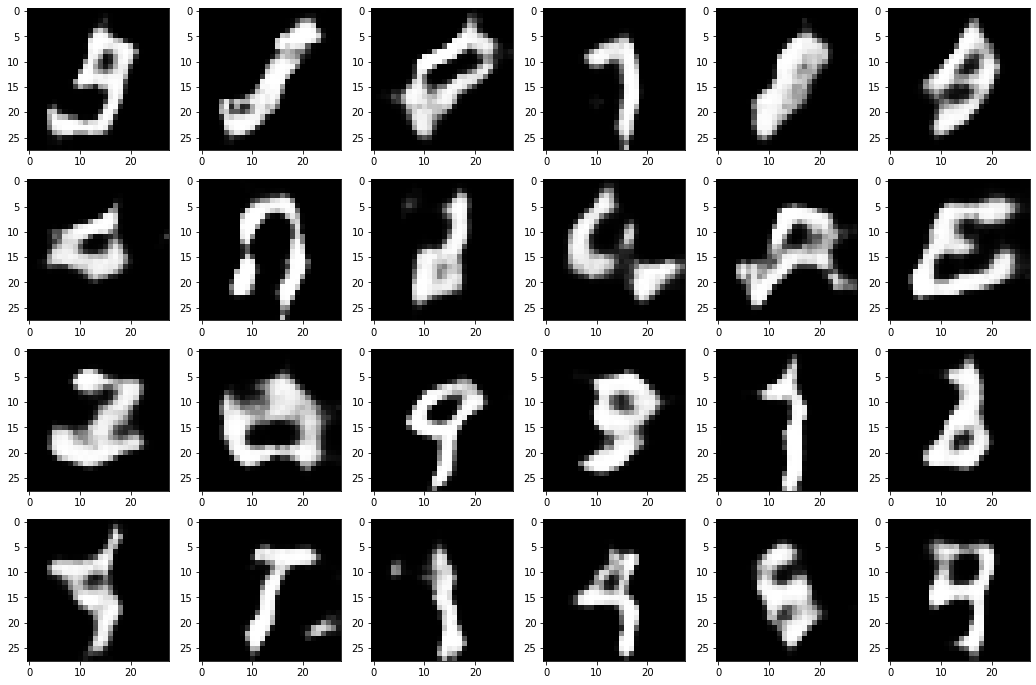

Epoch: 003: Gen Loss: -0.293, Disc Loss:-0.489, IS: 2.769
examples of generated images after 3 epochs


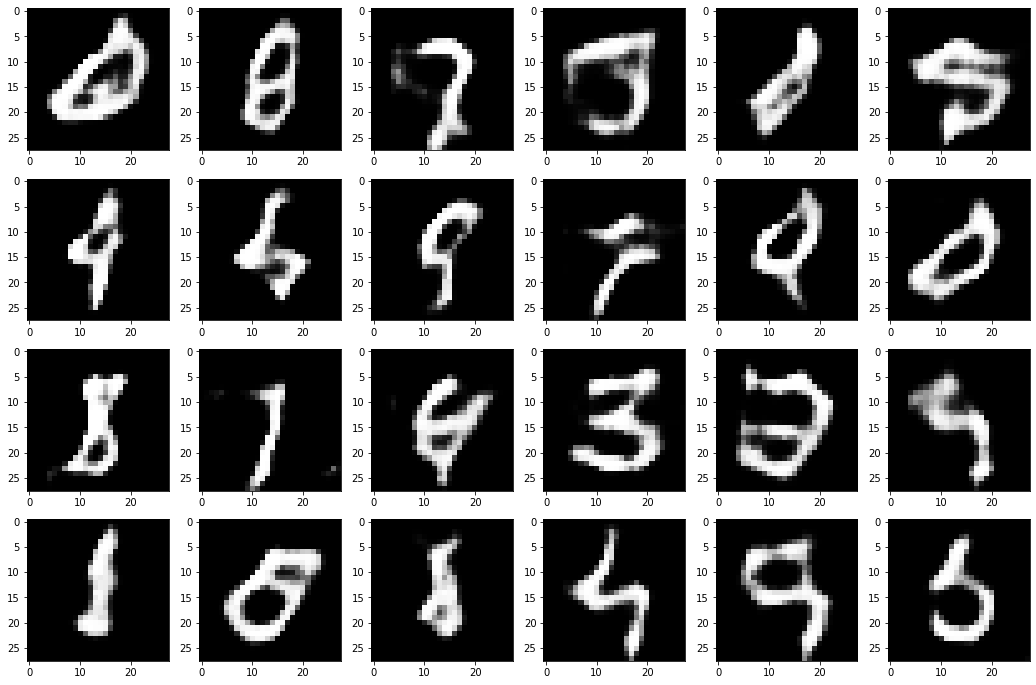

Epoch: 004: Gen Loss: -0.159, Disc Loss:-0.458, IS: 2.814
examples of generated images after 4 epochs


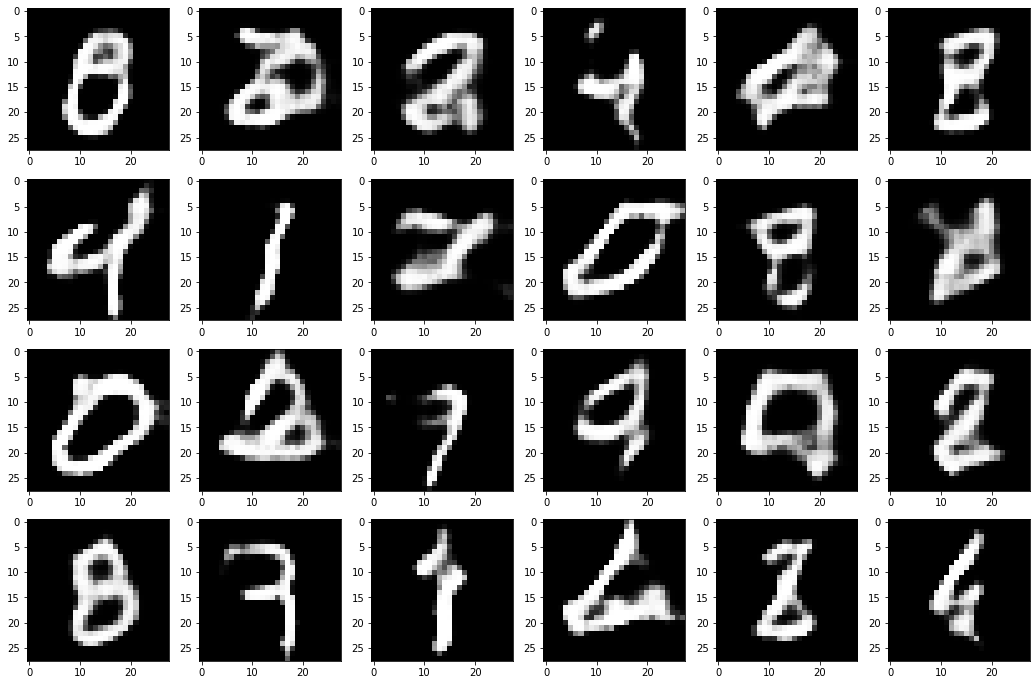

Epoch: 005: Gen Loss: -0.107, Disc Loss:-0.434, IS: 2.766
examples of generated images after 5 epochs


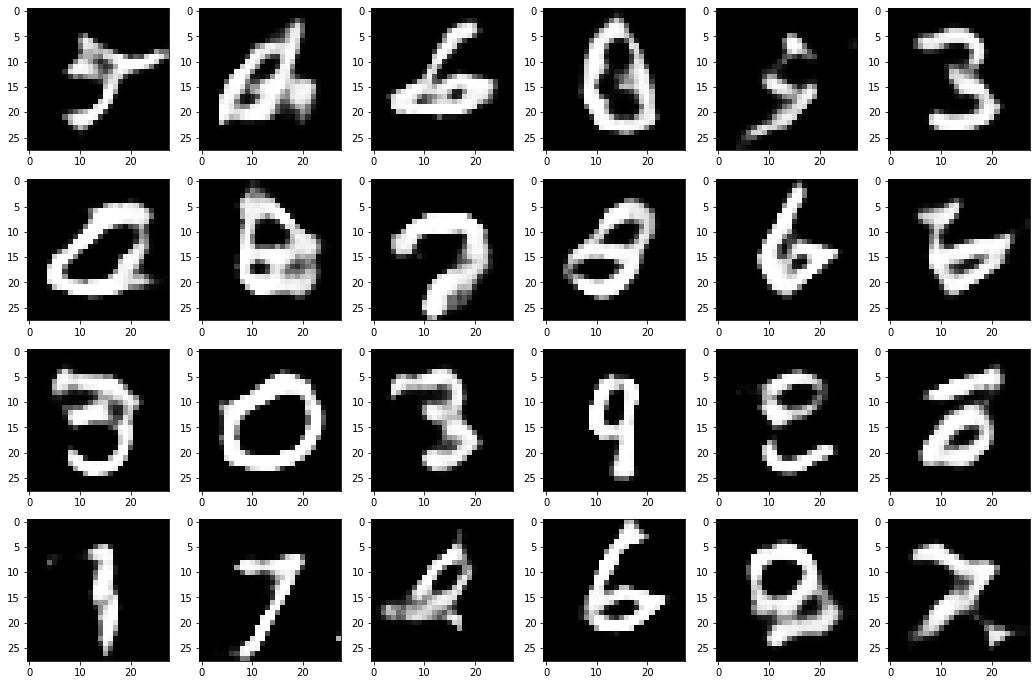

Epoch: 006: Gen Loss: -0.059, Disc Loss:-0.416, IS: 2.805
examples of generated images after 6 epochs


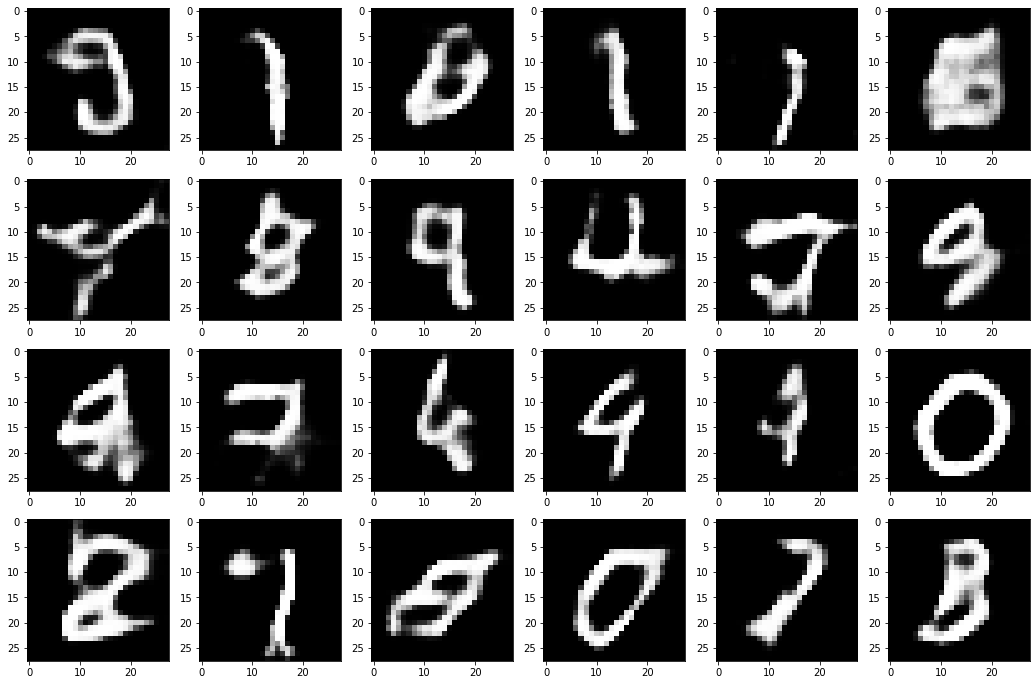

Epoch: 007: Gen Loss: -0.011, Disc Loss:-0.396, IS: 2.819
examples of generated images after 7 epochs


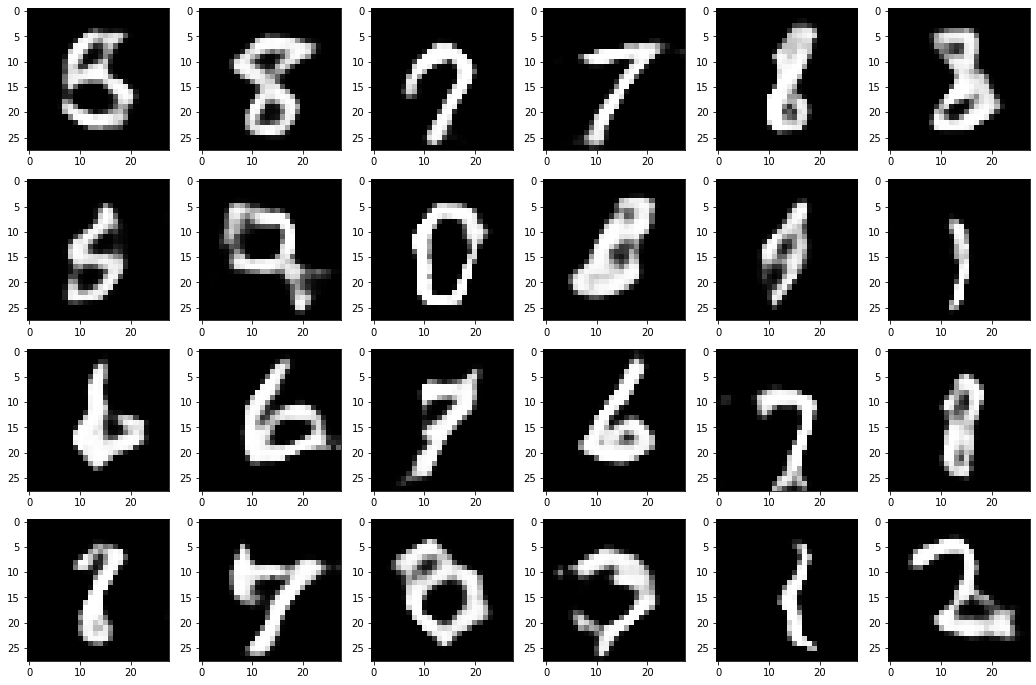

Epoch: 008: Gen Loss: -0.002, Disc Loss:-0.385, IS: 2.824
examples of generated images after 8 epochs


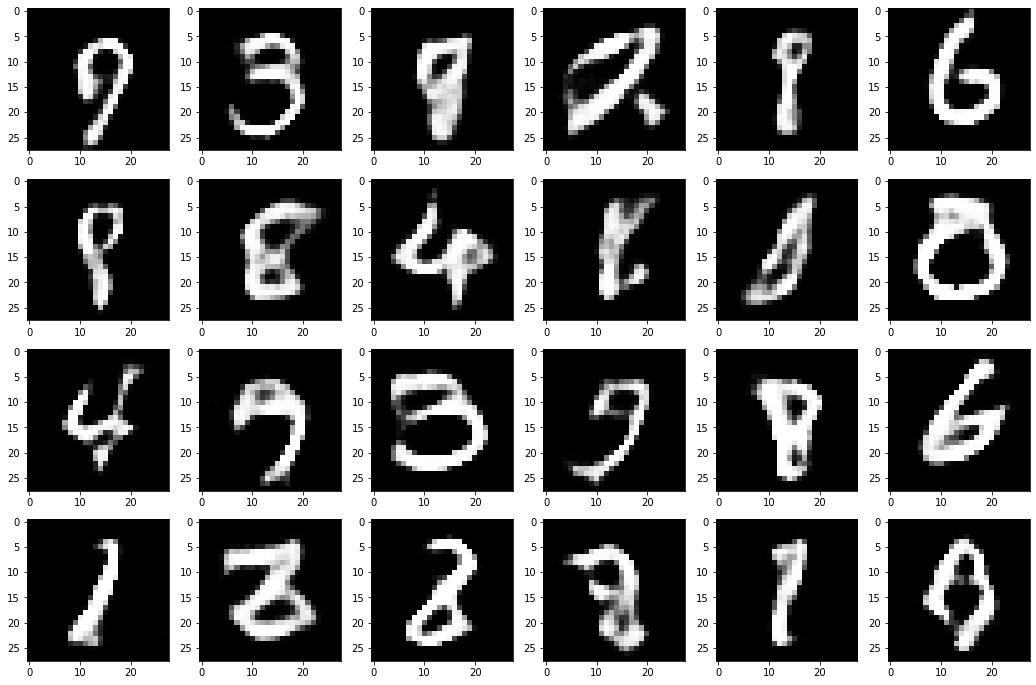

Epoch: 009: Gen Loss: -0.002, Disc Loss:-0.375, IS: 2.849
examples of generated images after 9 epochs


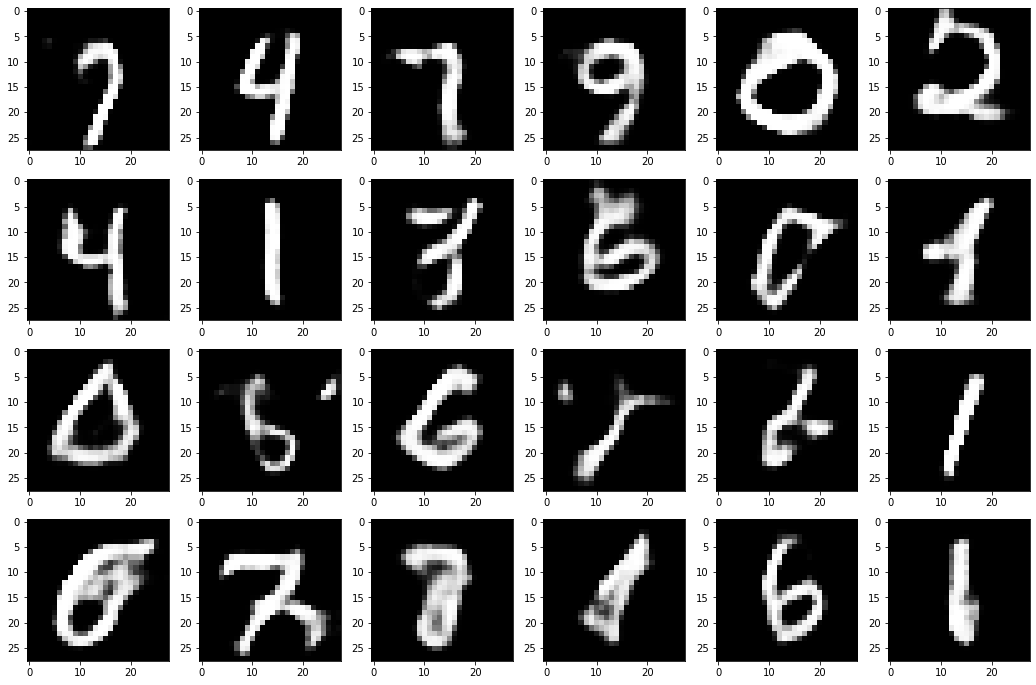

Epoch: 010: Gen Loss: 0.011, Disc Loss:-0.363, IS: 2.716
examples of generated images after 10 epochs


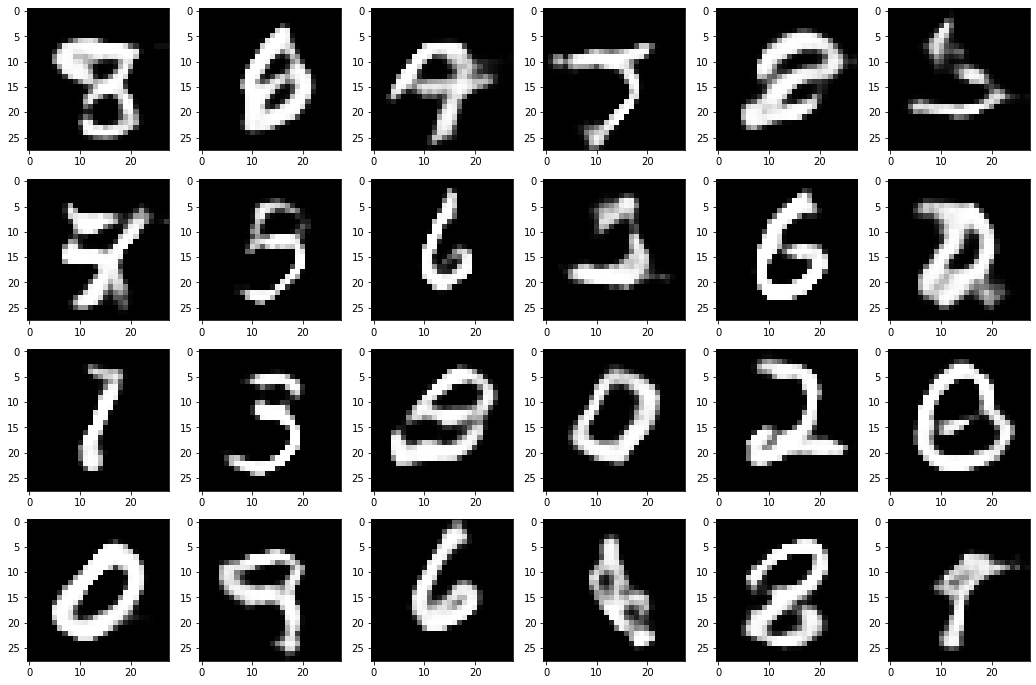

Epoch: 011: Gen Loss: 0.024, Disc Loss:-0.350, IS: 2.826
examples of generated images after 11 epochs


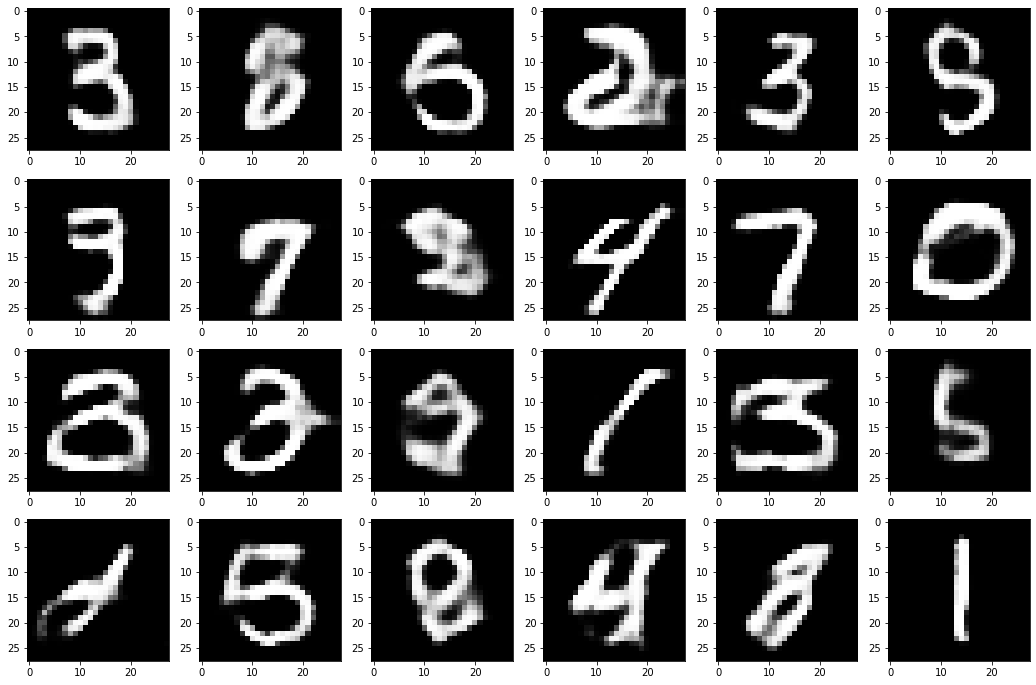

Epoch: 012: Gen Loss: 0.030, Disc Loss:-0.342, IS: 2.710
examples of generated images after 12 epochs


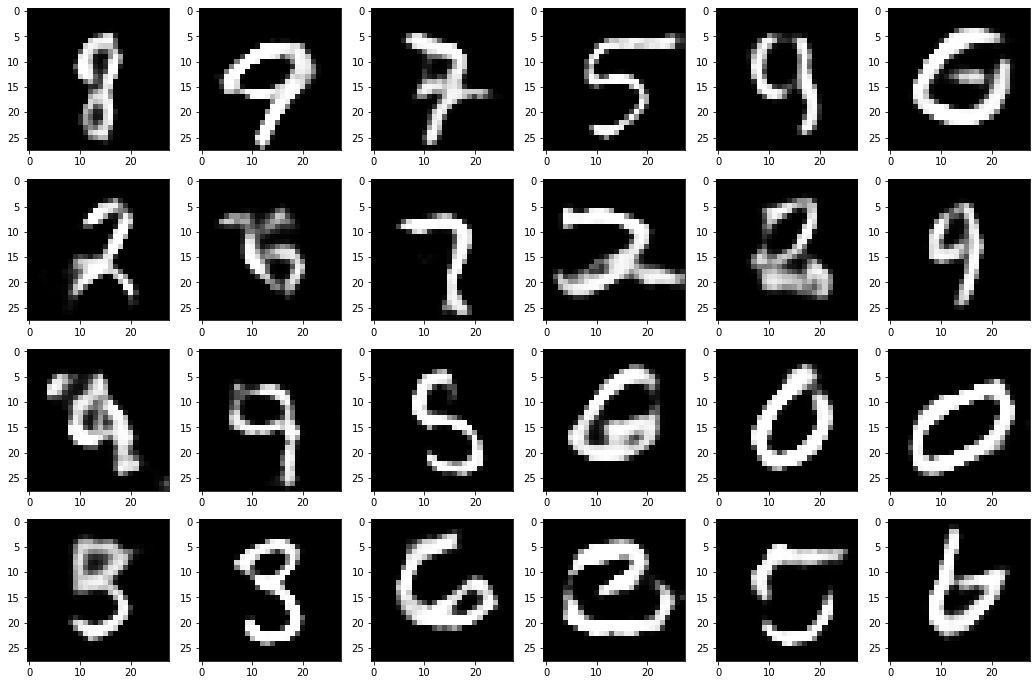

Epoch: 013: Gen Loss: 0.055, Disc Loss:-0.334, IS: 2.773
examples of generated images after 13 epochs


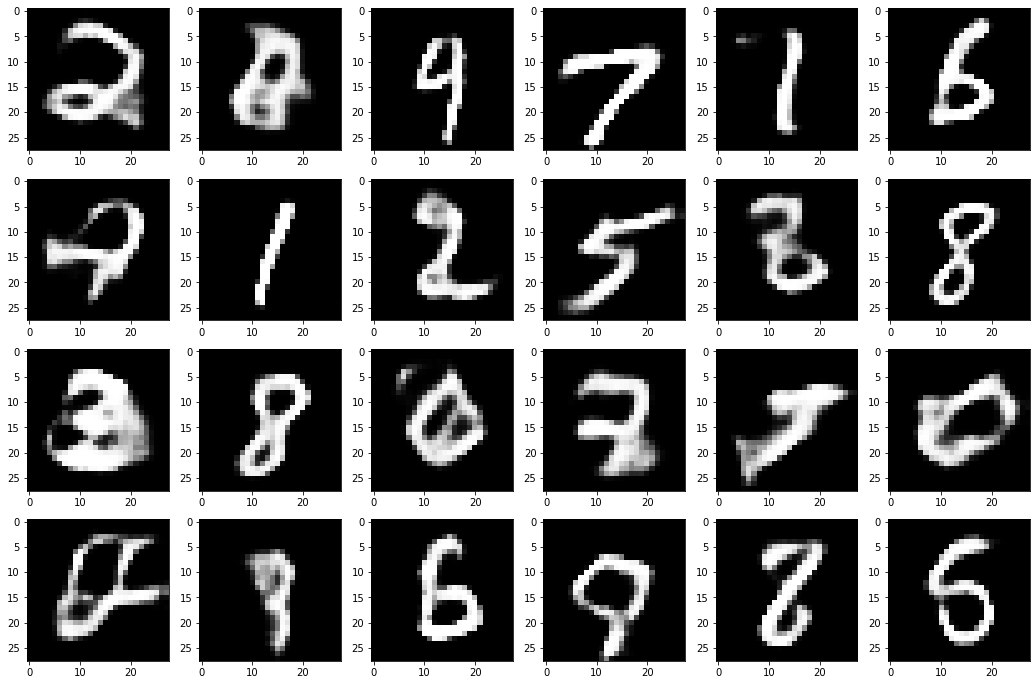

Epoch: 014: Gen Loss: 0.064, Disc Loss:-0.322, IS: 2.773
examples of generated images after 14 epochs


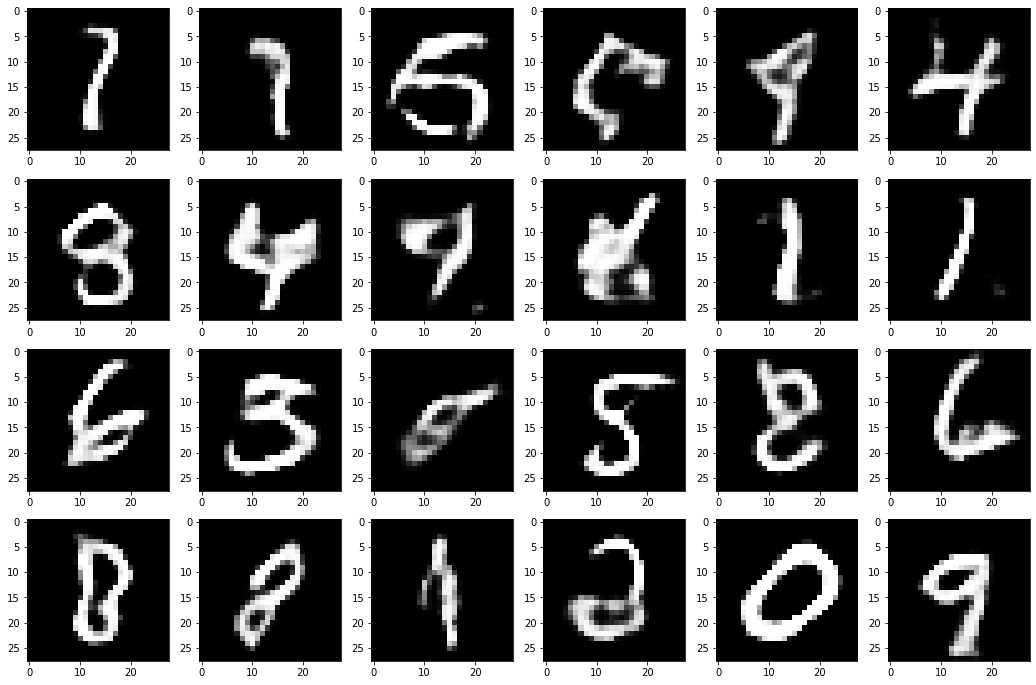

Epoch: 015: Gen Loss: 0.086, Disc Loss:-0.309, IS: 2.774
examples of generated images after 15 epochs


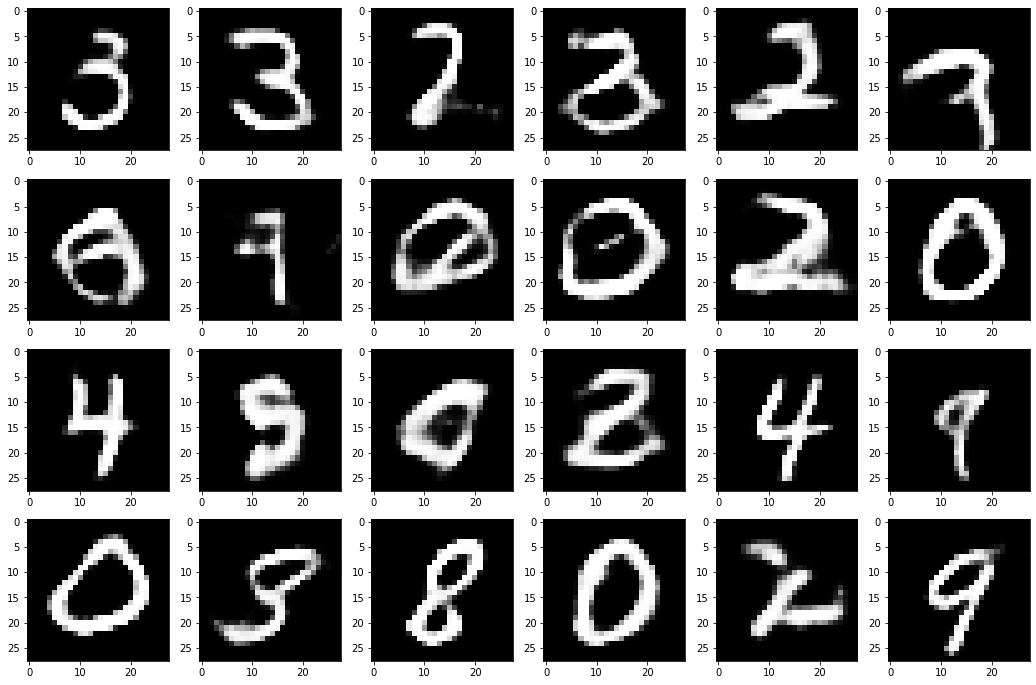

time: 764.0677880000003 sec


In [ ]:
wgangp = WGANGP(tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), x_train, batch_size=64, use_averaging=False,
                path='/content/drive/My Drive/Univ/Final models/Saved models/WGANGP Adam/')
t0 = time.clock()
wgangp.train(epochs=15)
print('time:', time.clock() - t0, 'sec')

Epoch: 016: Gen Loss: 0.081, Disc Loss:-0.309, IS: 2.702, IS_avr: 2.730
examples of generated images after 16 epochs


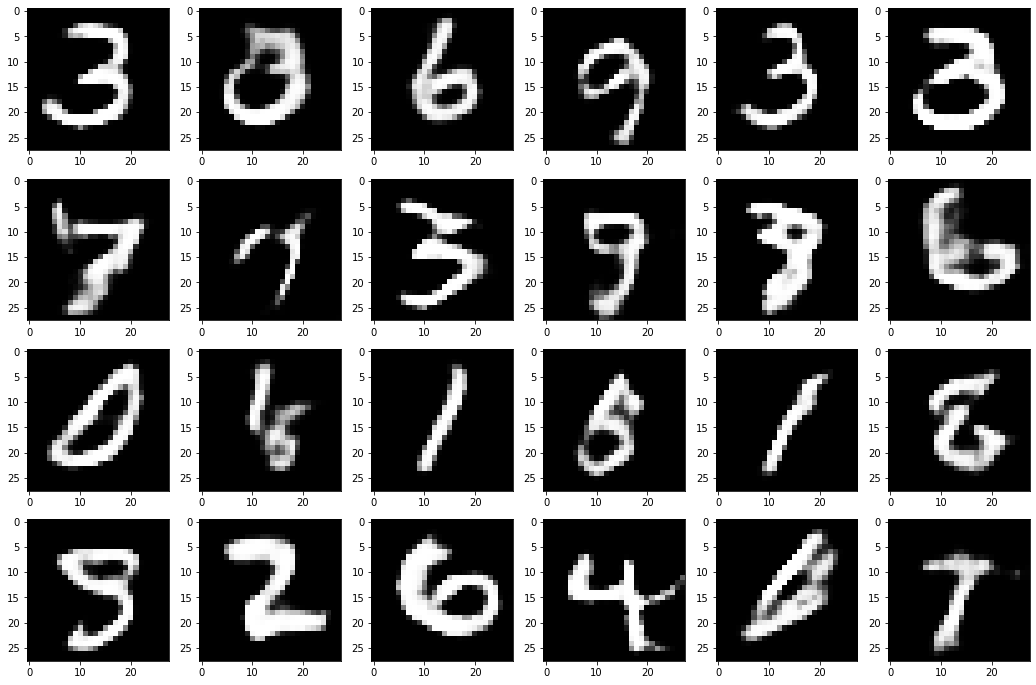

examples of generated images using average variables after 16 epochs


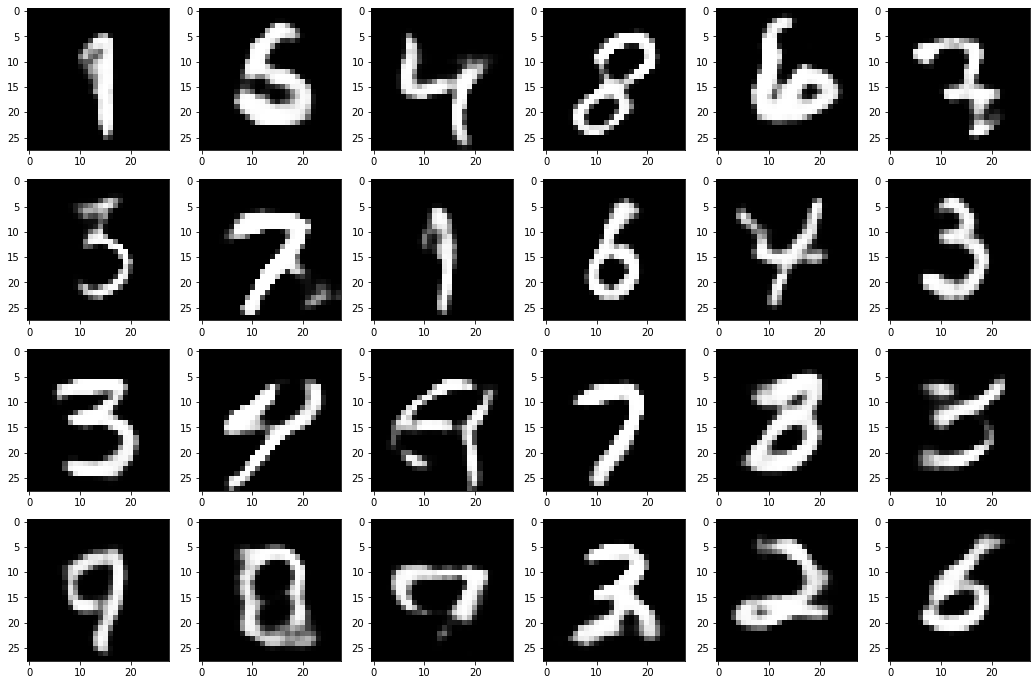

Epoch: 017: Gen Loss: 0.089, Disc Loss:-0.296, IS: 2.663, IS_avr: 2.783
examples of generated images after 17 epochs


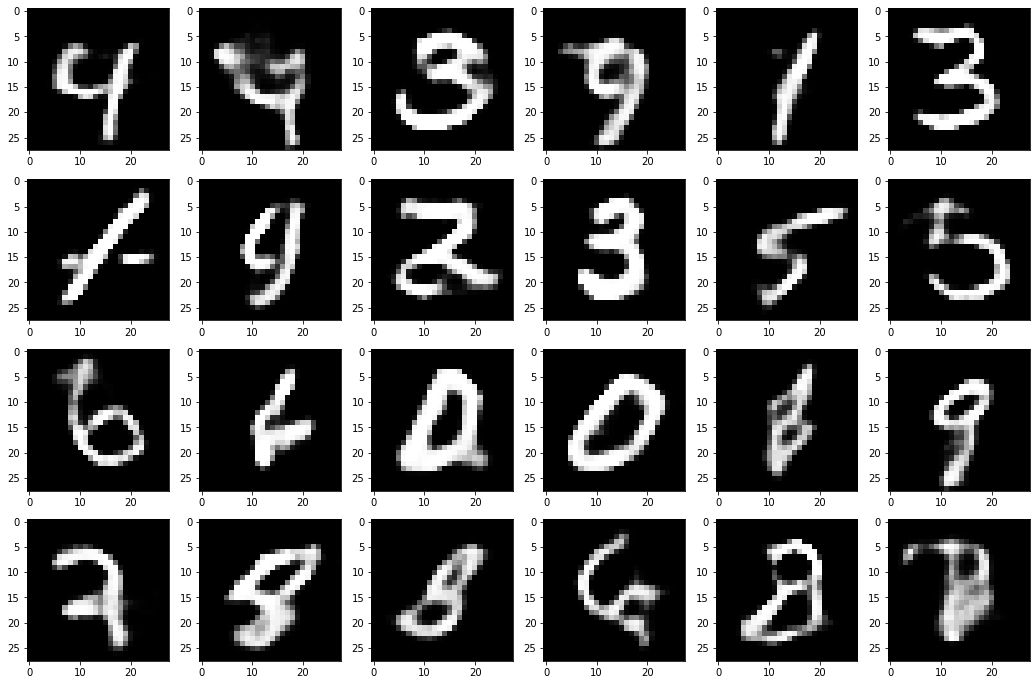

examples of generated images using average variables after 17 epochs


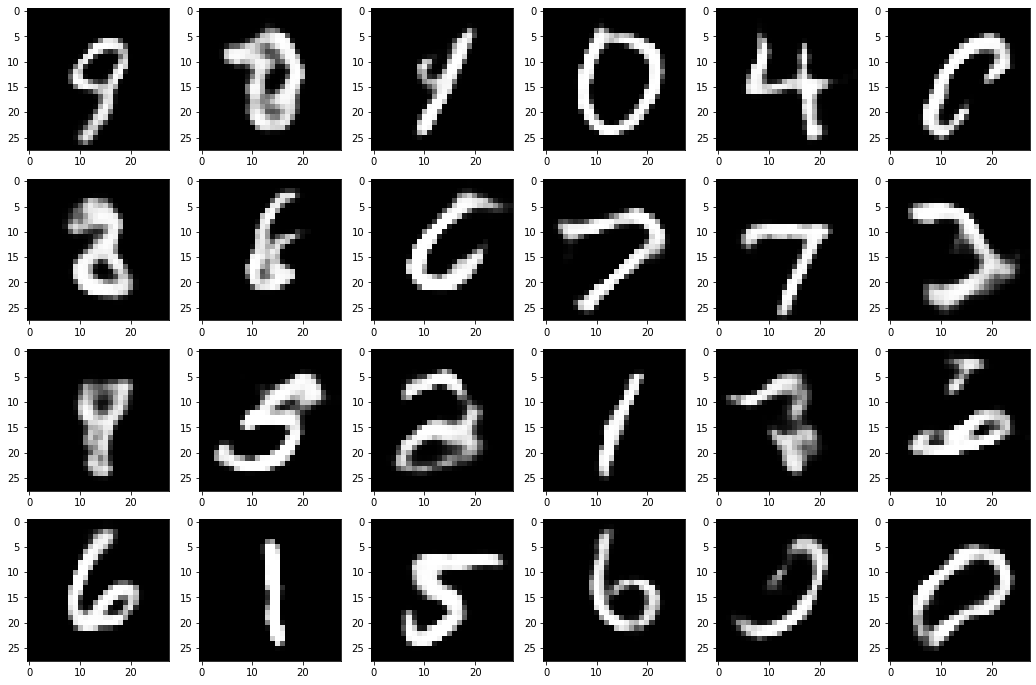

Epoch: 018: Gen Loss: 0.095, Disc Loss:-0.290, IS: 2.723, IS_avr: 2.726
examples of generated images after 18 epochs


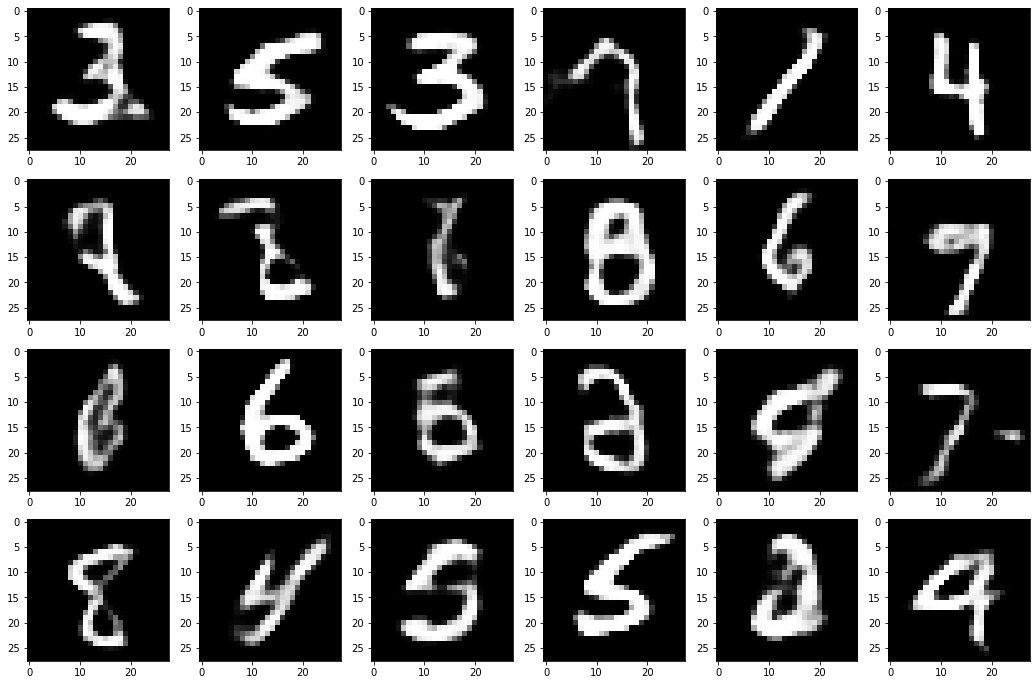

examples of generated images using average variables after 18 epochs


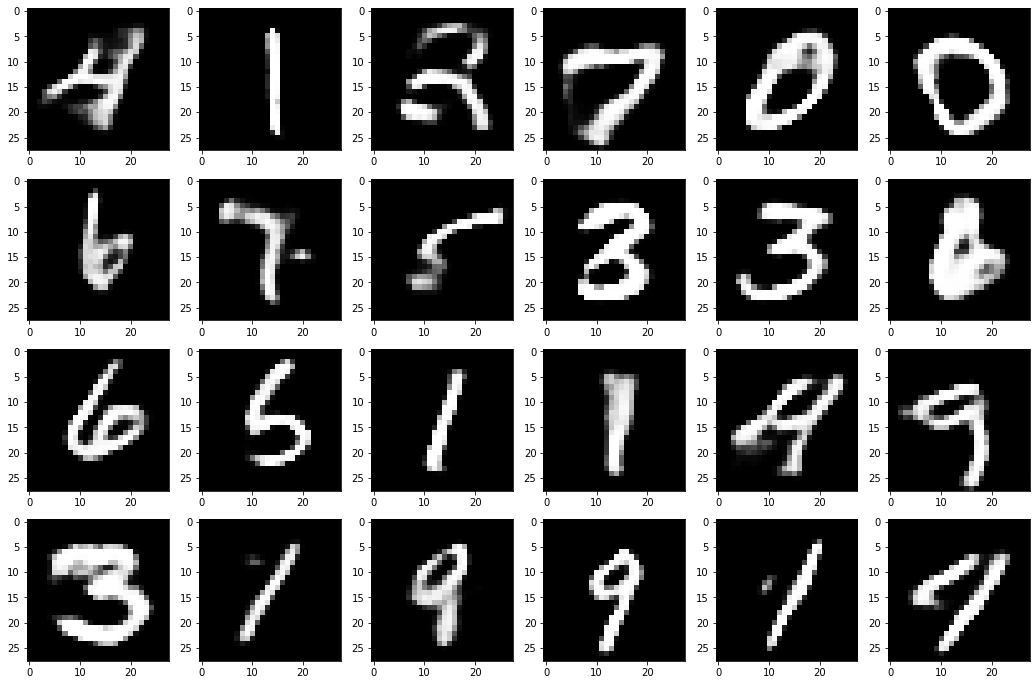

Epoch: 019: Gen Loss: 0.110, Disc Loss:-0.285, IS: 2.771, IS_avr: 2.646
examples of generated images after 19 epochs


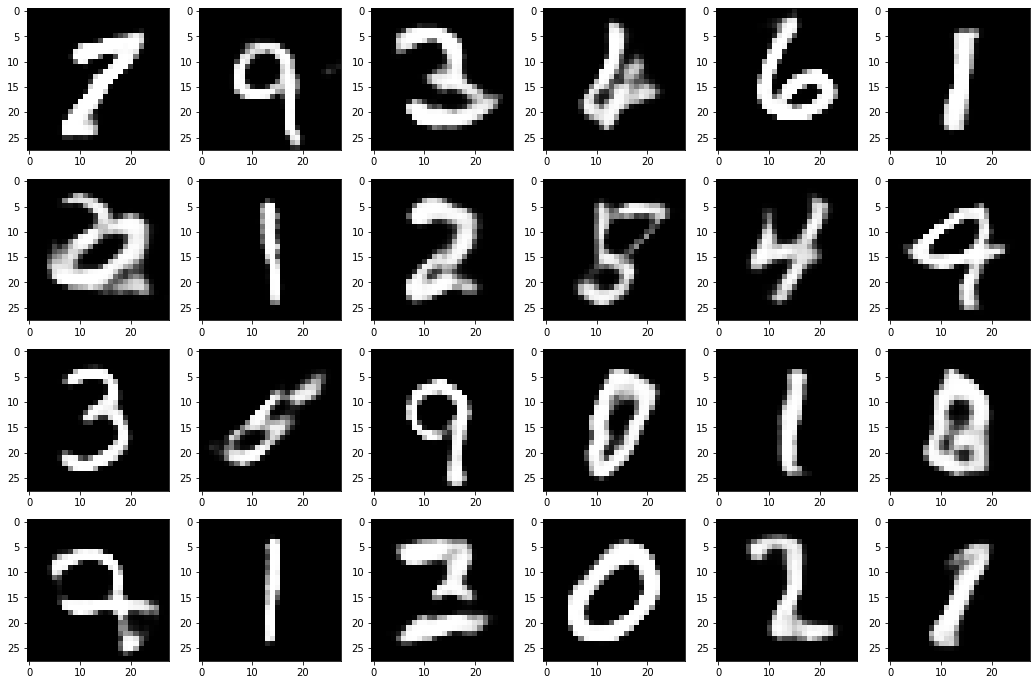

examples of generated images using average variables after 19 epochs


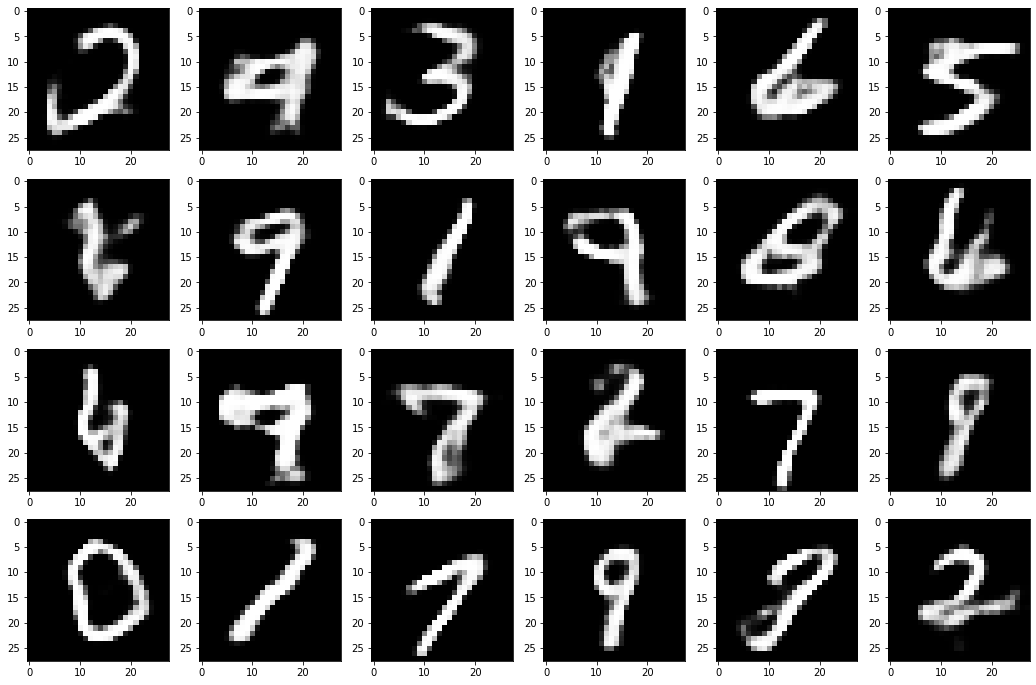

Epoch: 020: Gen Loss: 0.109, Disc Loss:-0.282, IS: 2.713, IS_avr: 2.716
examples of generated images after 20 epochs


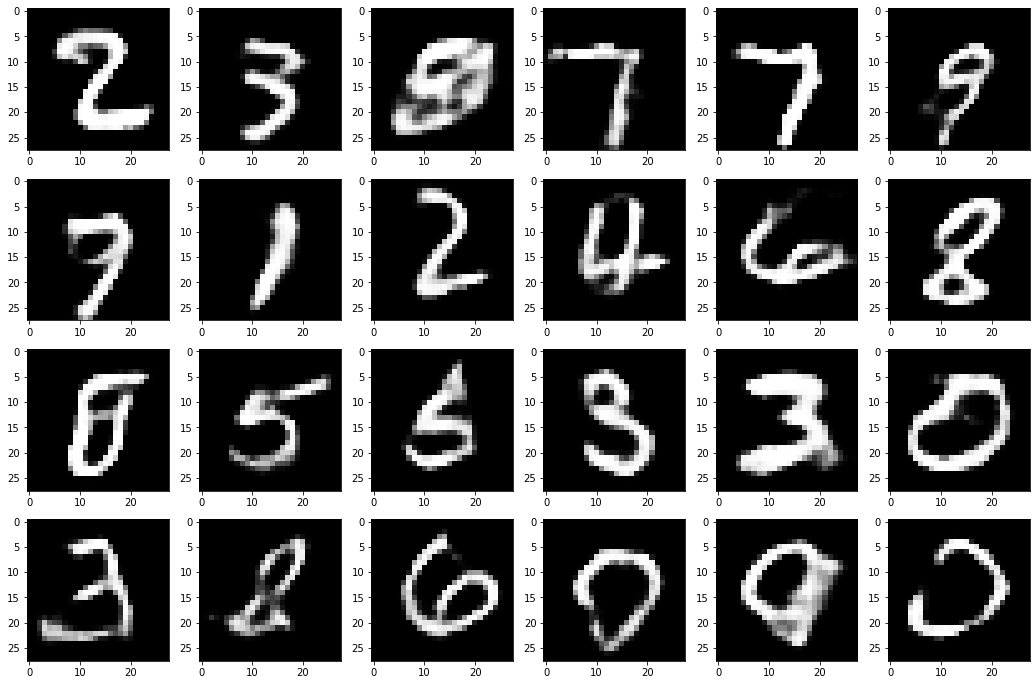

examples of generated images using average variables after 20 epochs


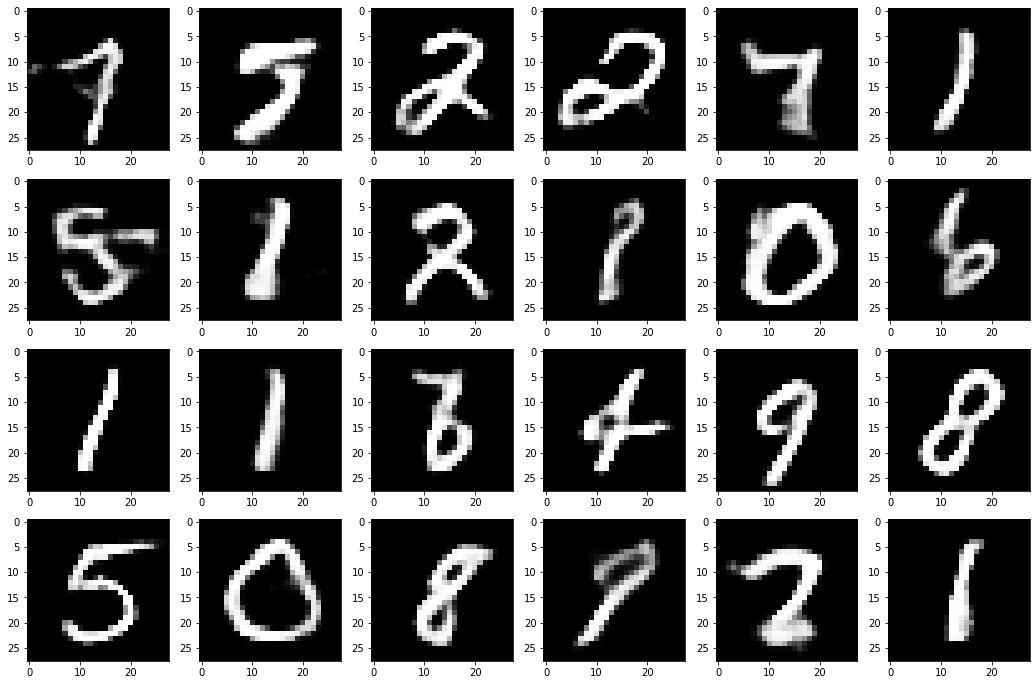

Epoch: 021: Gen Loss: 0.111, Disc Loss:-0.275, IS: 2.660, IS_avr: 2.764
examples of generated images after 21 epochs


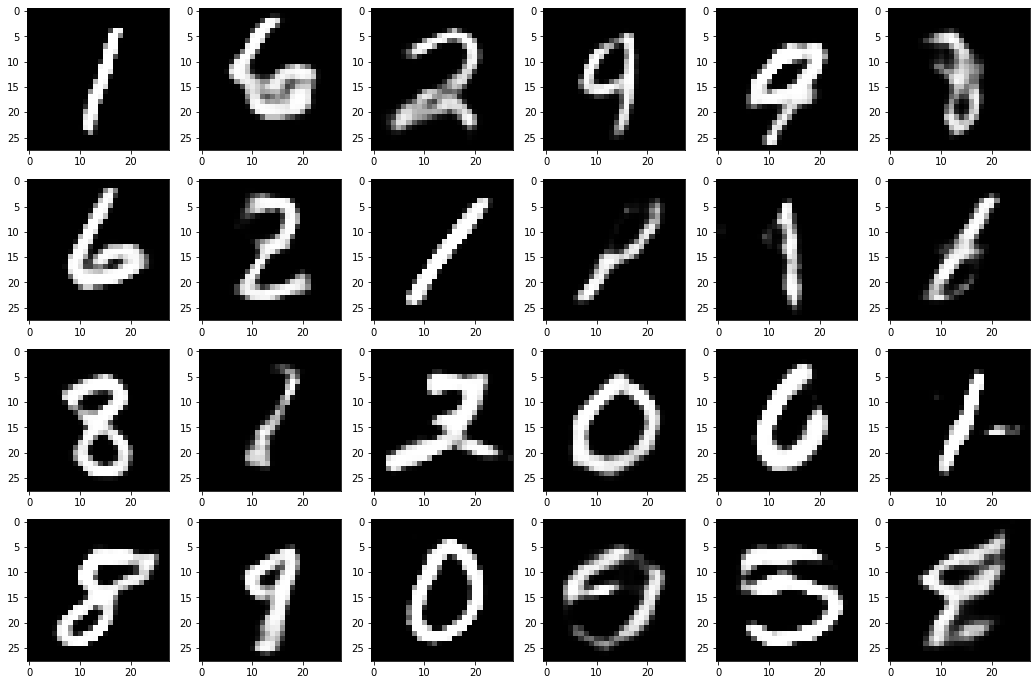

examples of generated images using average variables after 21 epochs


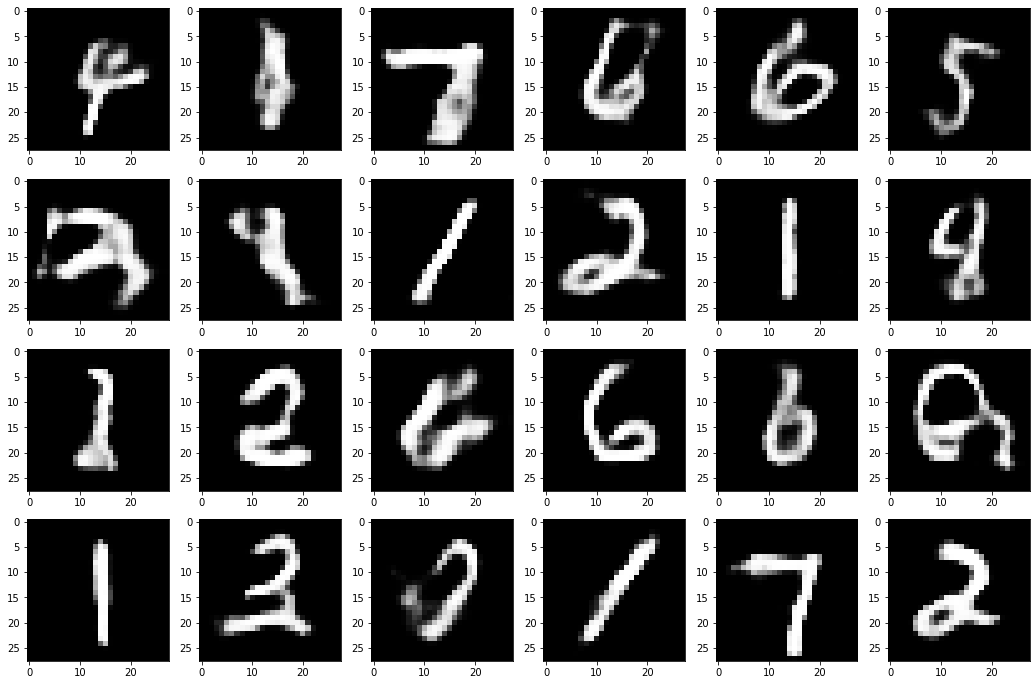

Epoch: 022: Gen Loss: 0.133, Disc Loss:-0.267, IS: 2.699, IS_avr: 2.758
examples of generated images after 22 epochs


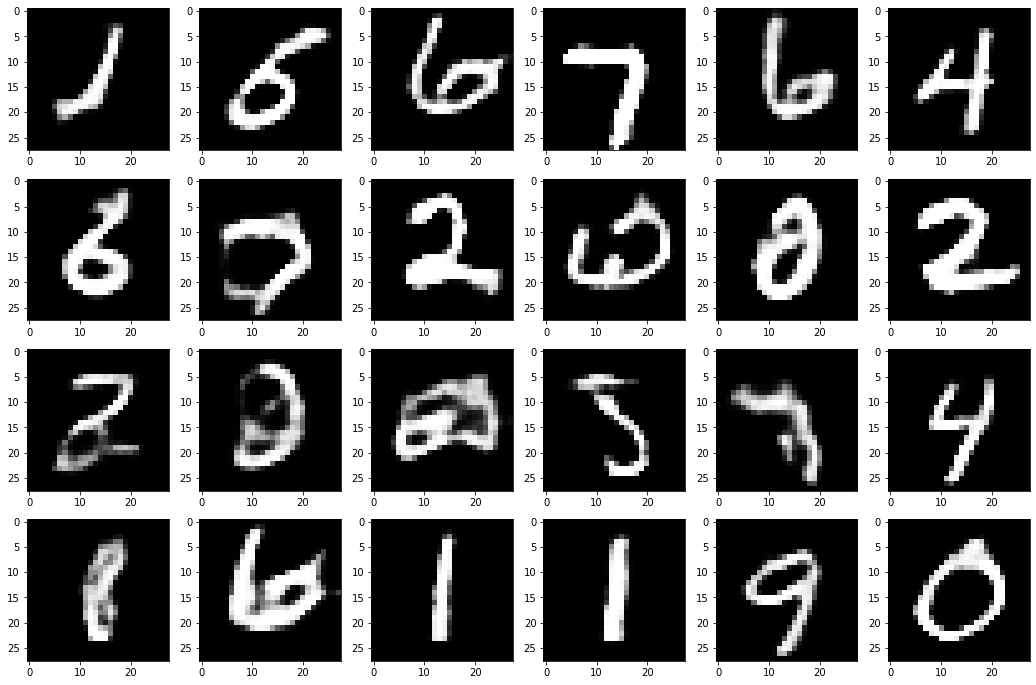

examples of generated images using average variables after 22 epochs


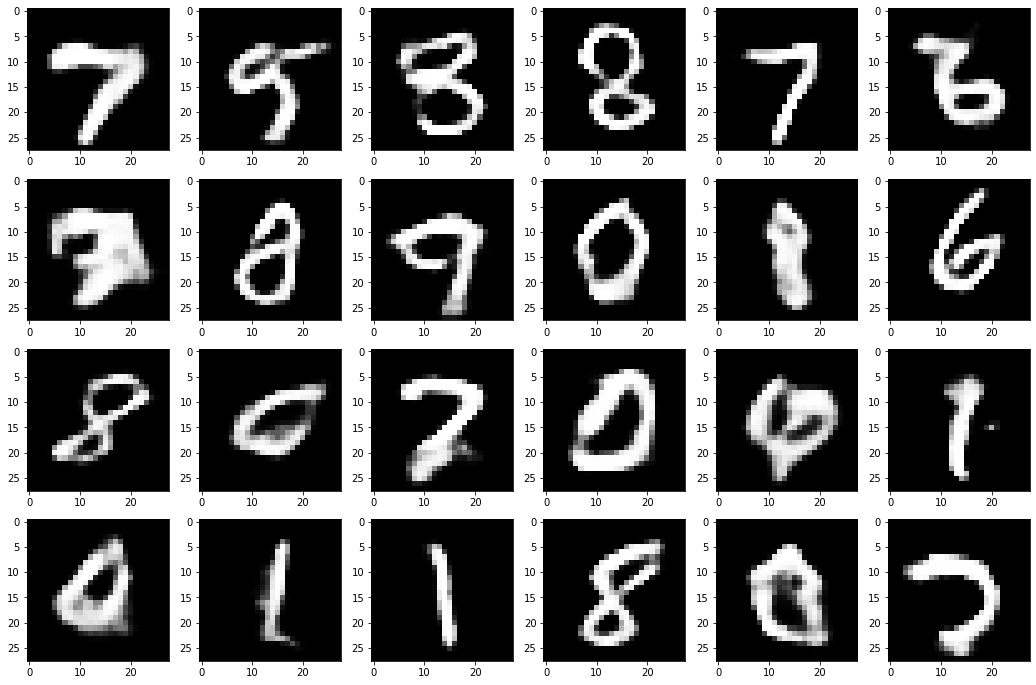

Epoch: 023: Gen Loss: 0.130, Disc Loss:-0.263, IS: 2.760, IS_avr: 2.807
examples of generated images after 23 epochs


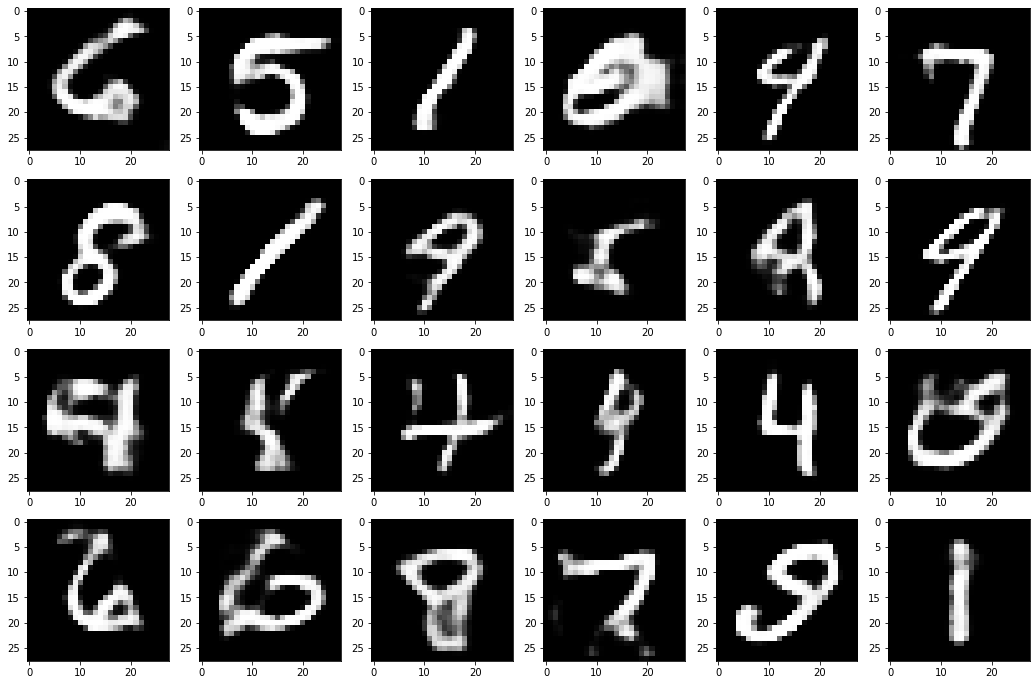

examples of generated images using average variables after 23 epochs


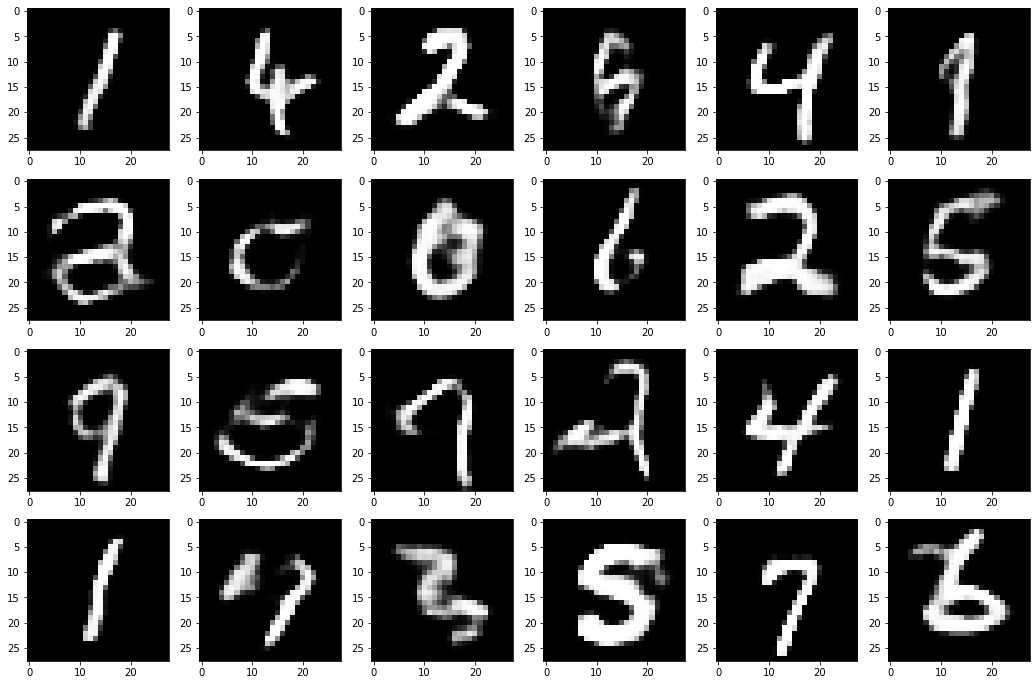

Epoch: 024: Gen Loss: 0.136, Disc Loss:-0.259, IS: 2.662, IS_avr: 2.760
examples of generated images after 24 epochs


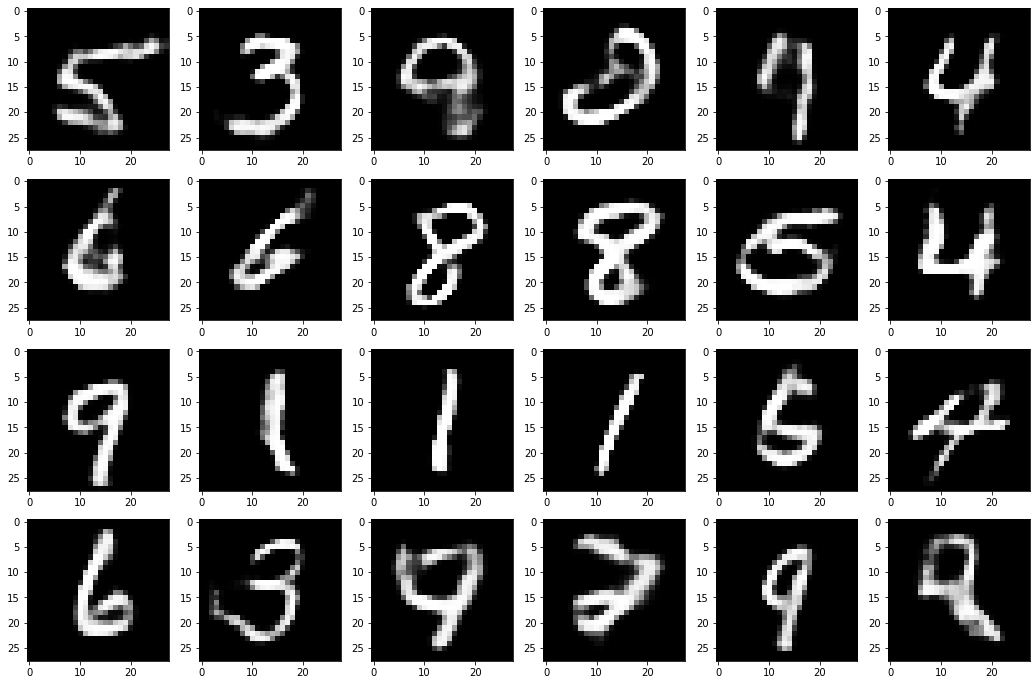

examples of generated images using average variables after 24 epochs


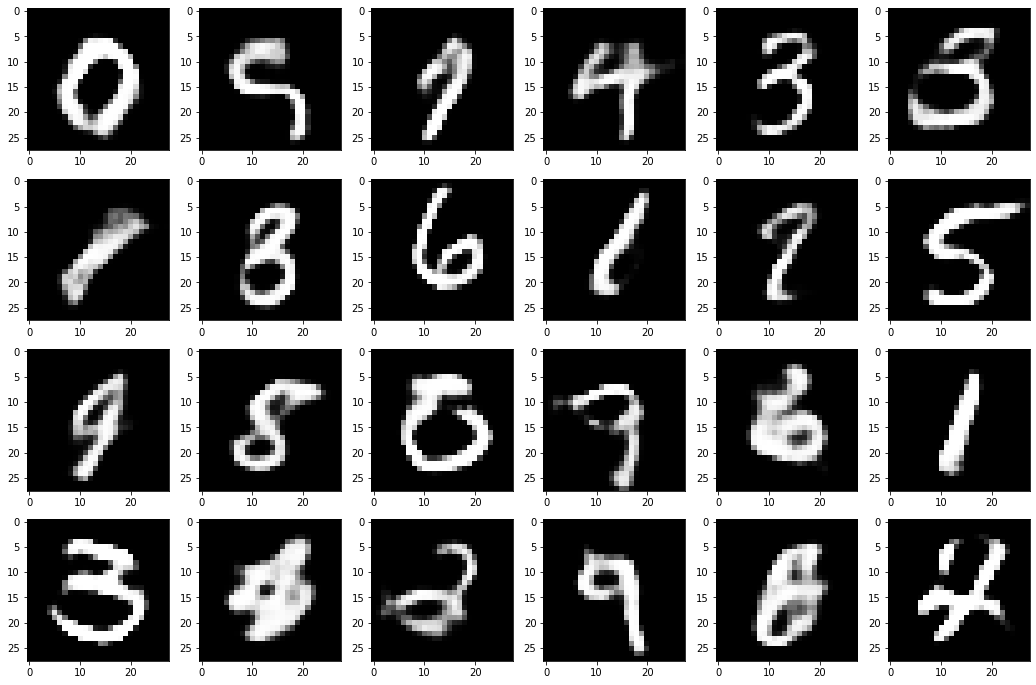

Epoch: 025: Gen Loss: 0.156, Disc Loss:-0.254, IS: 2.684, IS_avr: 2.780
examples of generated images after 25 epochs


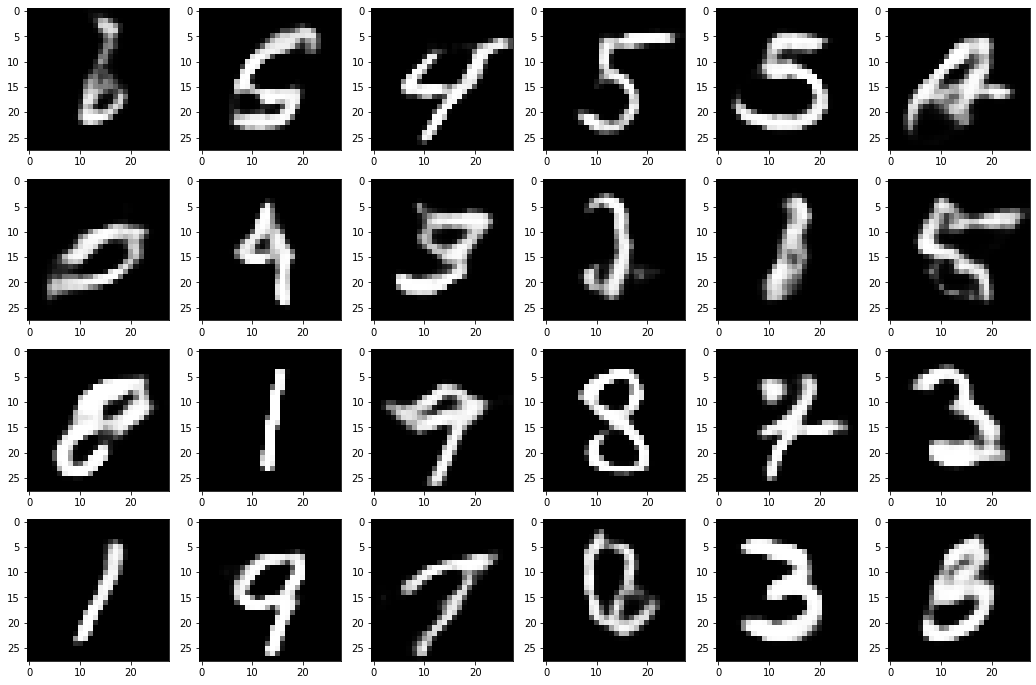

examples of generated images using average variables after 25 epochs


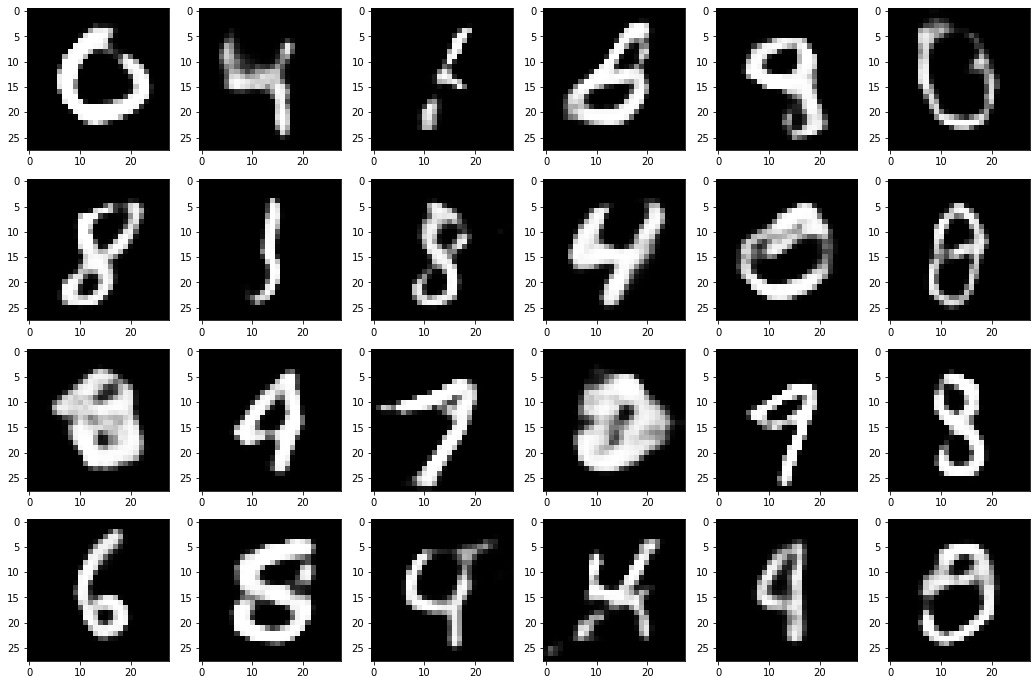

Epoch: 026: Gen Loss: 0.168, Disc Loss:-0.248, IS: 2.749, IS_avr: 2.819
examples of generated images after 26 epochs


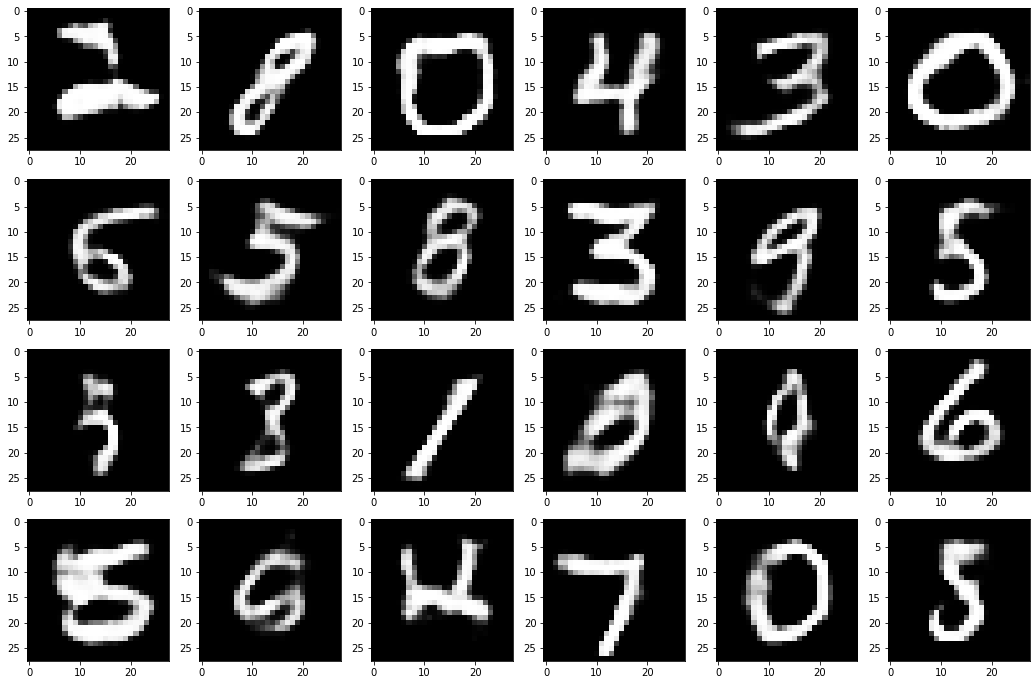

examples of generated images using average variables after 26 epochs


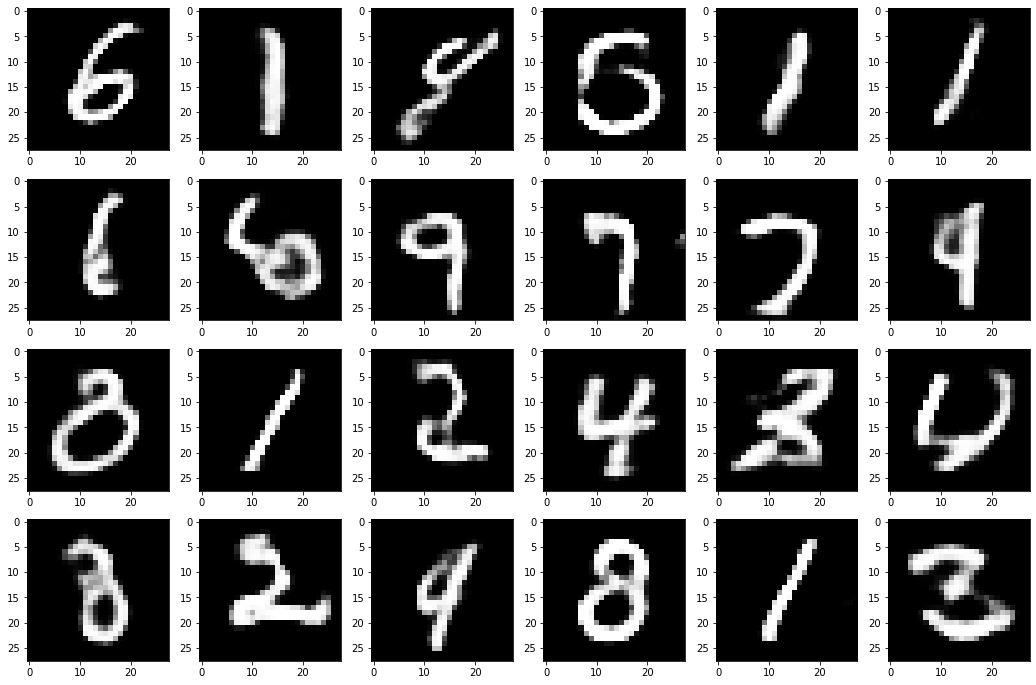

Epoch: 027: Gen Loss: 0.164, Disc Loss:-0.246, IS: 2.696, IS_avr: 2.741
examples of generated images after 27 epochs


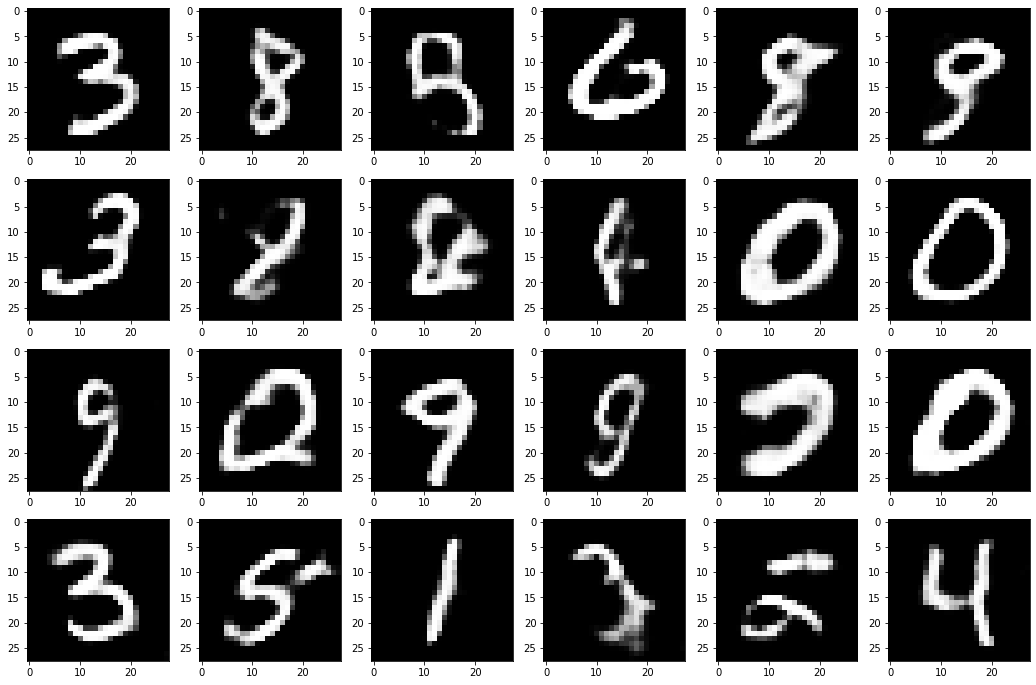

examples of generated images using average variables after 27 epochs


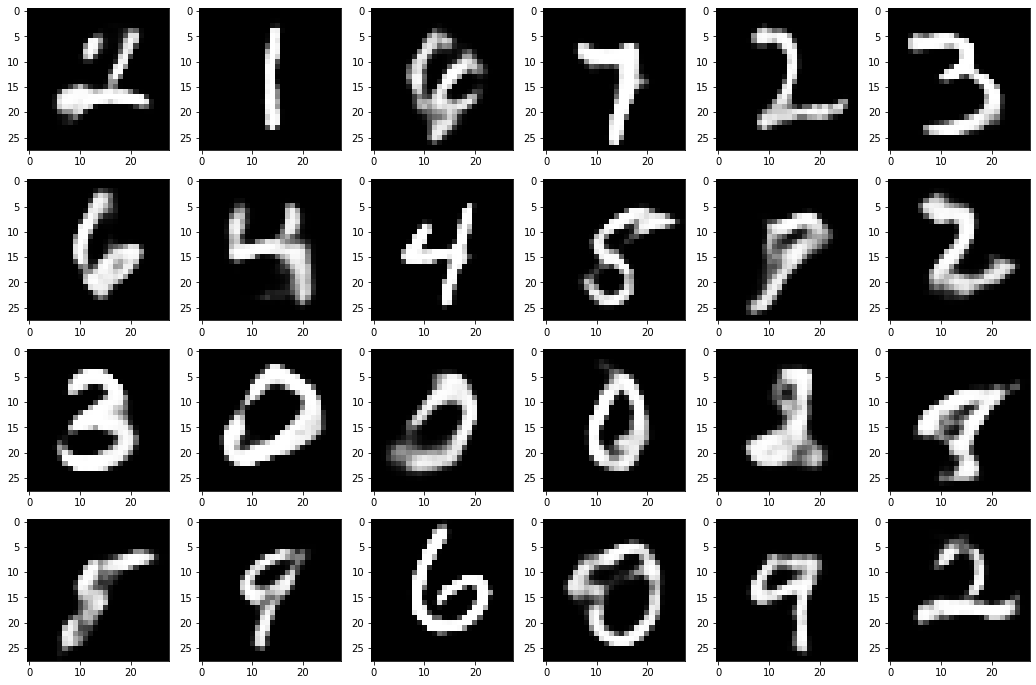

Epoch: 028: Gen Loss: 0.142, Disc Loss:-0.243, IS: 2.639, IS_avr: 2.690
examples of generated images after 28 epochs


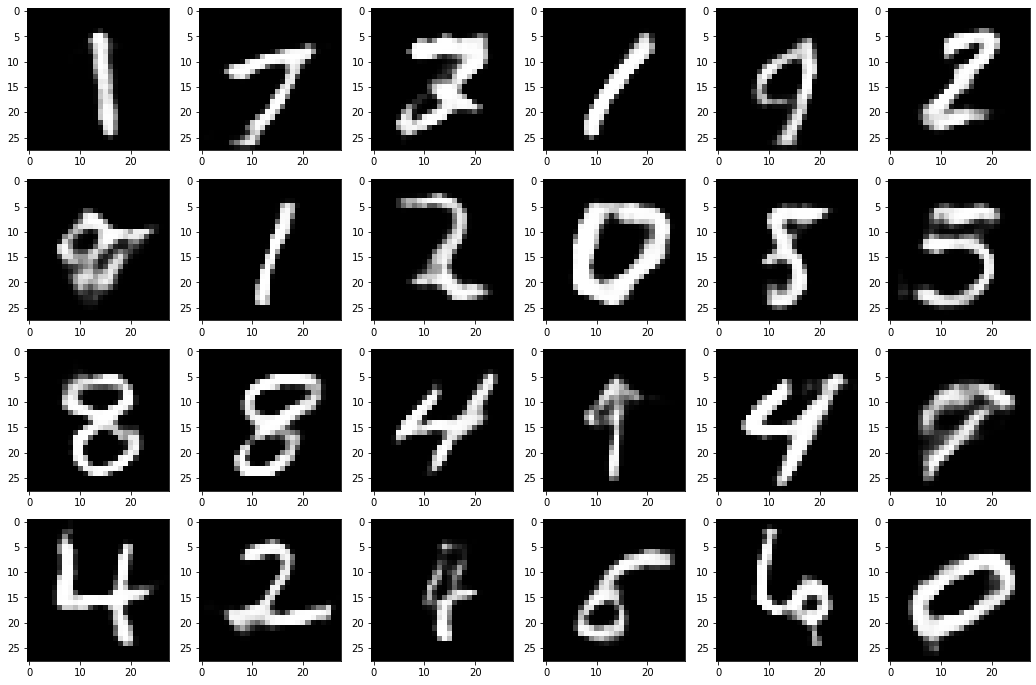

examples of generated images using average variables after 28 epochs


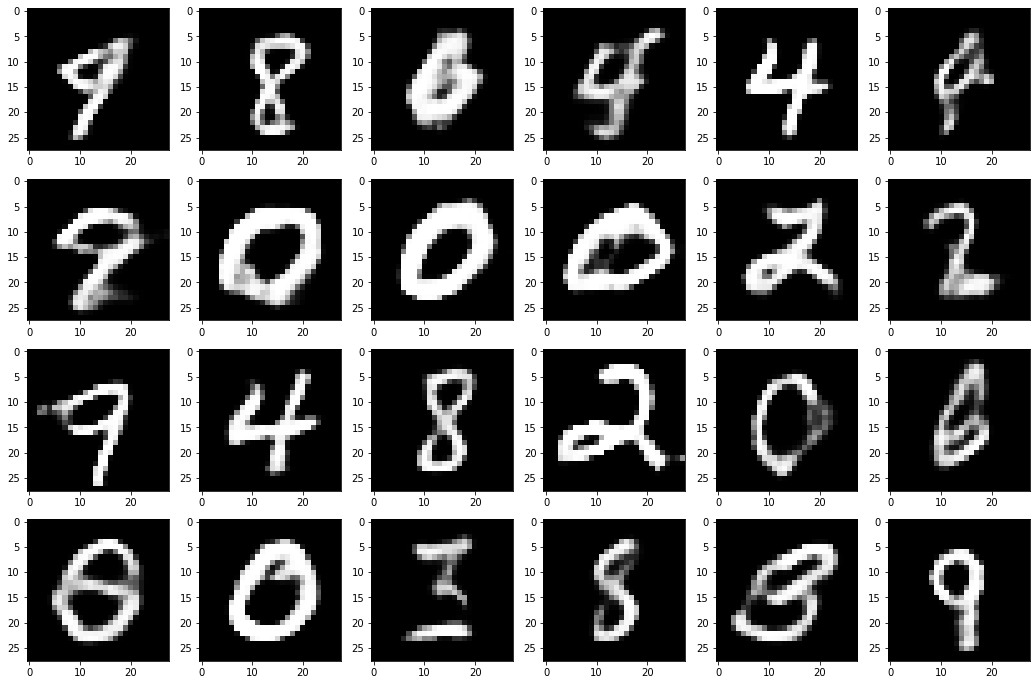

Epoch: 029: Gen Loss: 0.138, Disc Loss:-0.238, IS: 2.625, IS_avr: 2.693
examples of generated images after 29 epochs


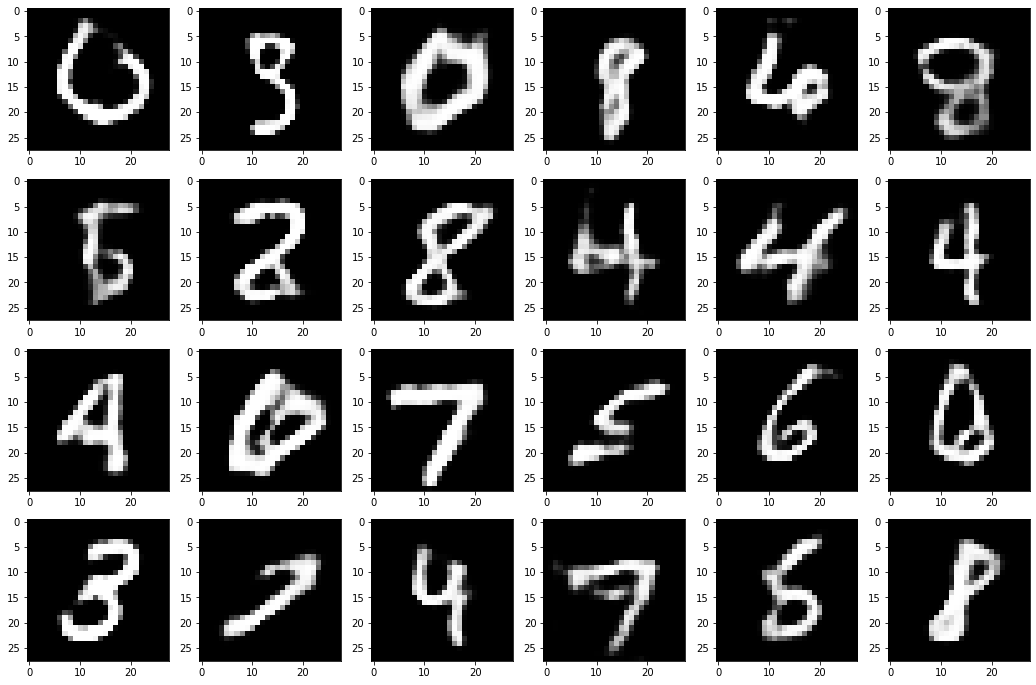

examples of generated images using average variables after 29 epochs


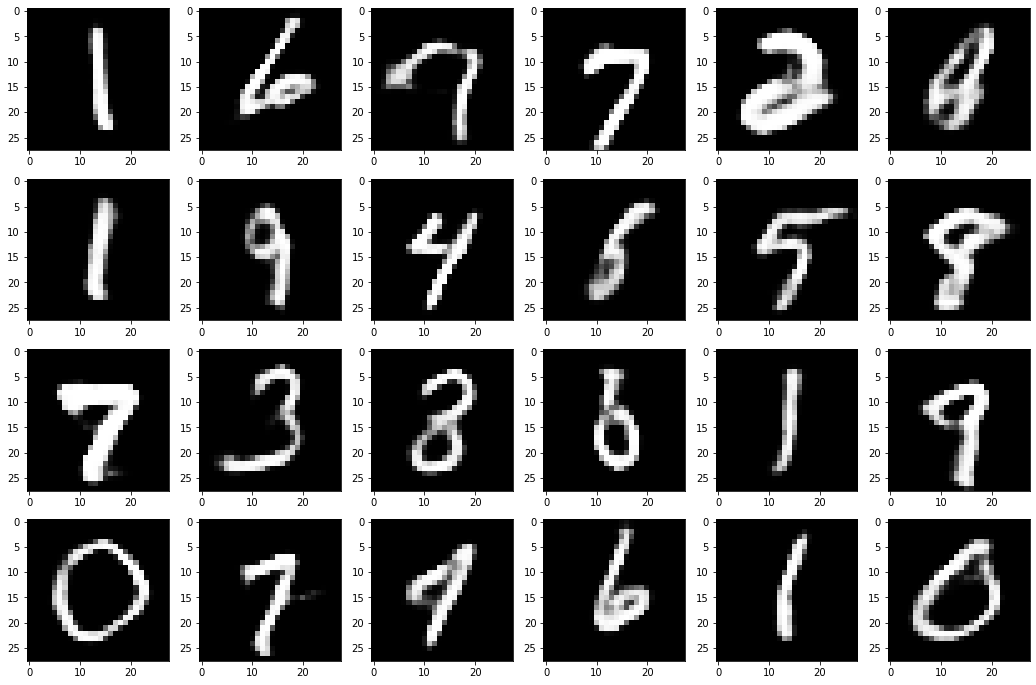

Epoch: 030: Gen Loss: 0.144, Disc Loss:-0.234, IS: 2.696, IS_avr: 2.620
examples of generated images after 30 epochs


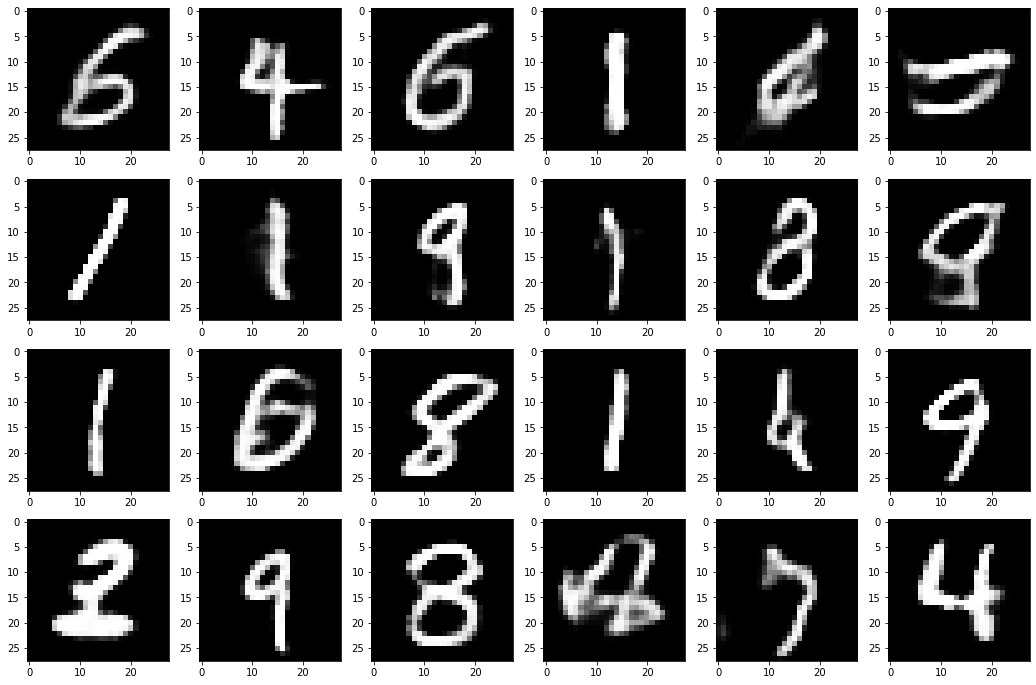

examples of generated images using average variables after 30 epochs


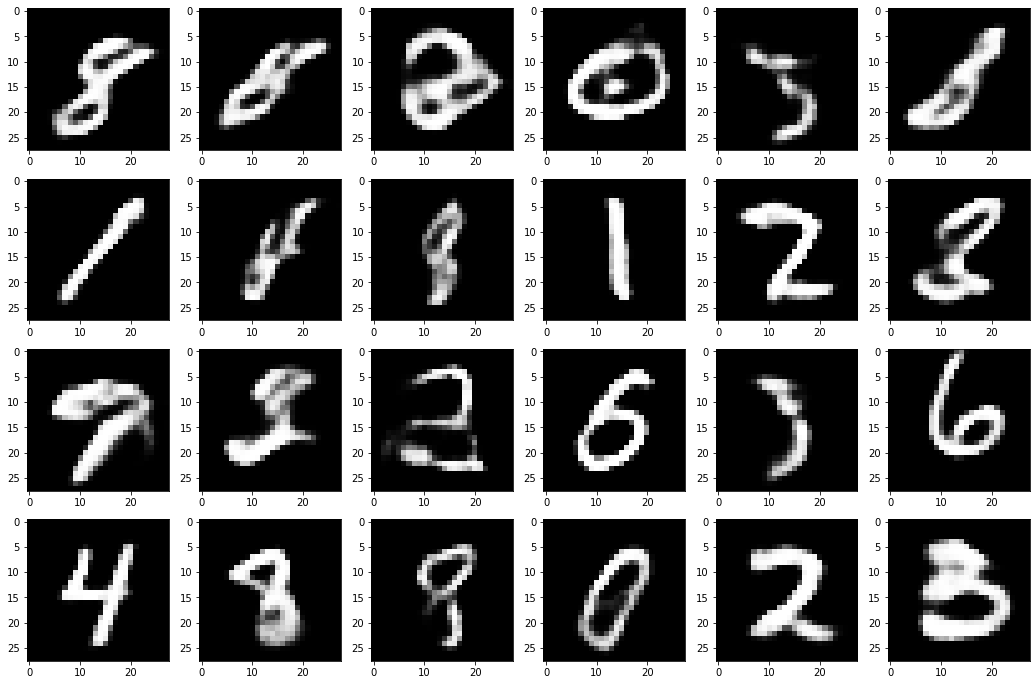

time: 1297.0463769999997 sec


In [ ]:
wgangp.use_averaging = True
t0 = time.clock()
wgangp.train(epochs=15)
print('time:', time.clock() - t0, 'sec')

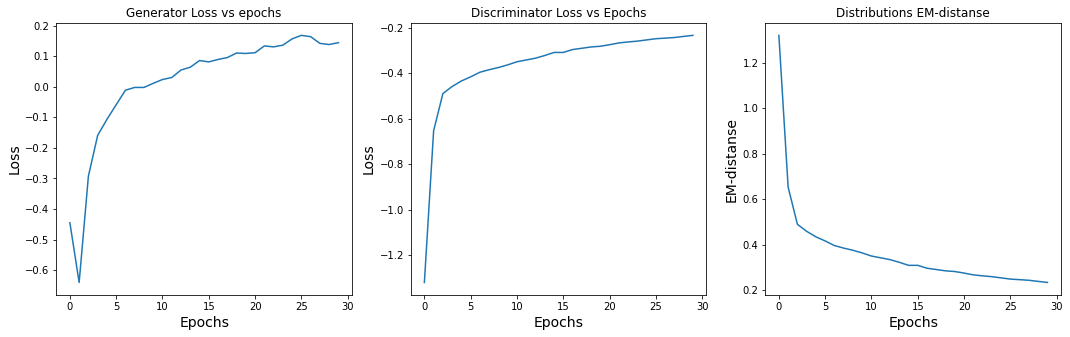

In [ ]:
wgangp.draw_losses_per_epoch_graphic()

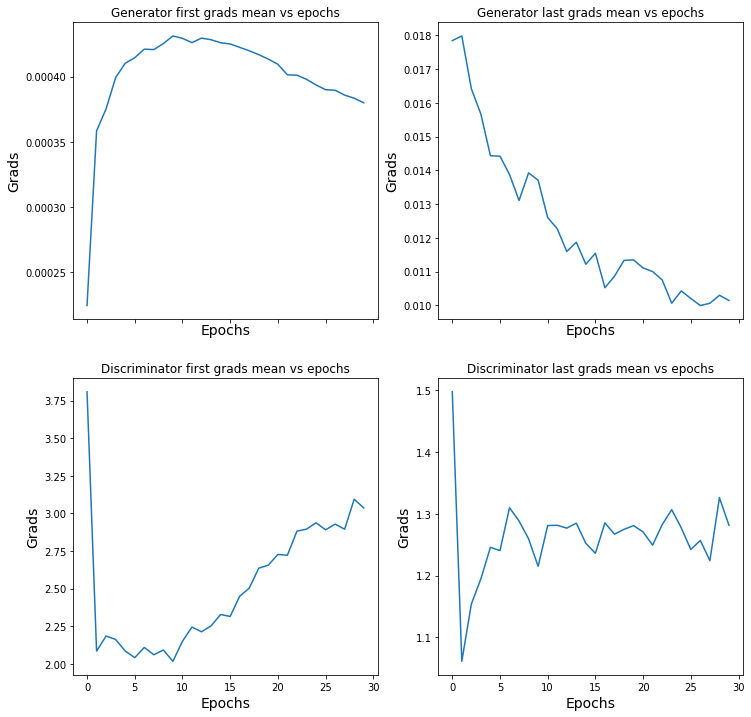

In [ ]:
wgangp.draw_grads_per_epoch_graphic()

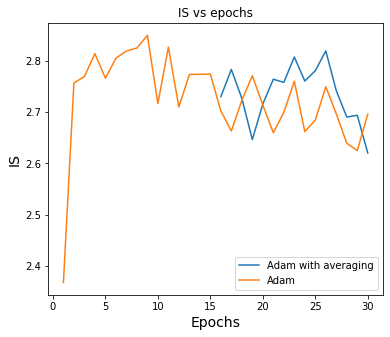

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5))  
axes.set_xlabel("Epochs", fontsize=14)
axes.set_ylabel("IS", fontsize=14)
axes.set_title('IS vs epochs')
x1 = [x for x in (np.arange(15)+16)]
axes.plot(x1, wgangp.IS_for_avr_per_epoch, label = 'Adam with averaging')
x2 = [x for x in (np.arange(30)+1)]
axes.plot(x2, wgangp.IS_per_epoch, label = 'Adam')
axes.legend()
plt.show()

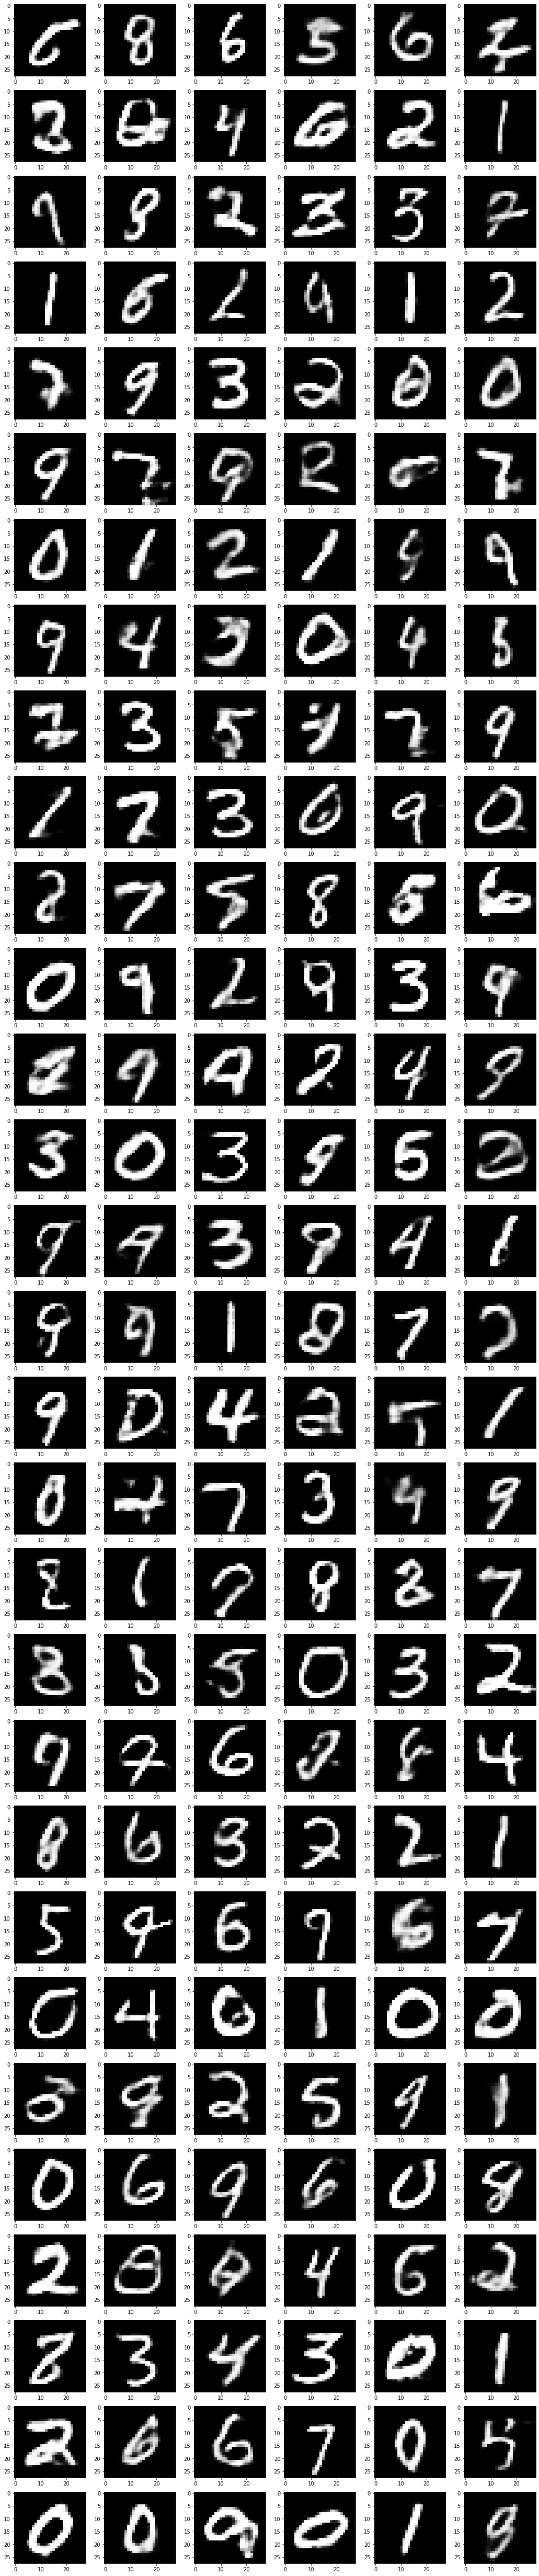

In [ ]:
wgangp.draw_generated_images(rows=30, cols=6)

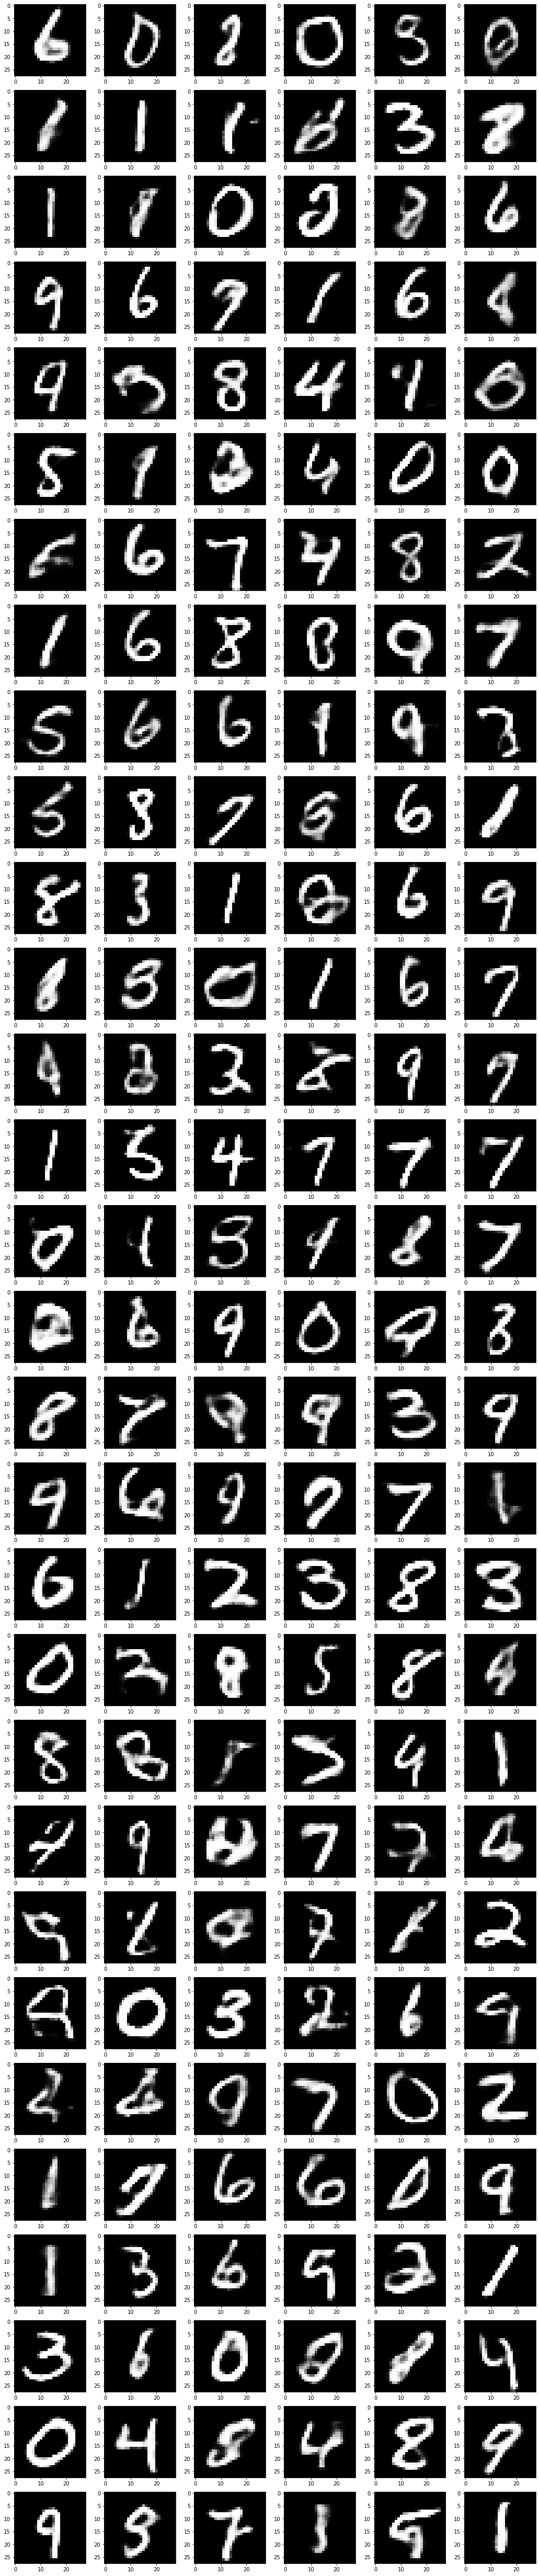

In [ ]:
wgangp.draw_generated_images(rows=30, cols=6, is_from_gen_avr=True)

**Optimistic Adam**

In [ ]:
# Importent: remove tf.function decorators from CGAN class!
wgangp = WGANGP(OptimisticAdam(learning_rate=0.0002, beta_1=0.5), x_train, batch_size=64, use_averaging=False,
                path='/content/drive/My Drive/Univ/Final models/Saved models/WGANGP OptimisticAdam\')
t0 = time.clock()
wgangp.train(epochs=15)
print('time:', time.clock() - t0, 'sec')

In [ ]:
wgangp.use_averaging = True
t0 = time.clock()
wgangp.train(epochs=15)
print('time:', time.clock() - t0, 'sec')

In [ ]:
wgangp.draw_losses_per_epoch_graphic()

In [ ]:
wgangp.draw_grads_per_epoch_graphic()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5))  
axes.set_xlabel("Epochs", fontsize=14)
axes.set_ylabel("IS", fontsize=14)
axes.set_title('IS vs epochs')
x1 = [x for x in (np.arange(15)+16)]
axes.plot(x1, wgangp.IS_for_avr_per_epoch, label = 'Adam with averaging')
x2 = [x for x in (np.arange(30)+1)]
axes.plot(x2, wgangp.IS_per_epoch, label = 'Adam')
axes.legend()
plt.show()

In [ ]:
wgangp.draw_generated_images(rows=30, cols=6)

In [ ]:
wgangp.draw_generated_images(rows=30, cols=6, is_from_gen_avr=True)